# REINFORCE and REINFORCE with baseline for continuous action spaces 

In this notebook we implement the Monte-Carlo based Reinforcement Learning algorithms, REINFORCE and REINFORCE with baseline for **continuous** action spaces, as they are introduced in the book by Sutton & Barto, Reinforcement Learning An Introduction (Second edition). The two algorithms are extensions of the discrete ones, which are derived from the *Policy Gradient Theorem* introduced in Chapter 13 of the book. When working with the *Gymnasium* (Formerly known as Gym) package, continuous action spaces are introduced as `Box(low, high, shape, dtype)` objects (see [`Box`](https://gymnasium.farama.org/api/spaces/fundamental/#gymnasium.spaces.Box) for more details).

Specifically in this notebook, we will work with the *LunarLander-v2* **continuous** environment illustrated below, the gif was borrowed from [LunarLander Gymnasium webpage](https://gymnasium.farama.org/environments/box2d/lunar_lander/).


<img src="../assets/lunar_lander.gif">

So, let's start.

In [65]:
## Incomment the installation commands below only if running from Google Colab
## In case running locally, all the needed packages are listed in the requirements.txt in the main directory.

# !pip install -q torch
# !pip install -q gymnasium[box2d]

## Imports
We will use the PyTorch package for the Policy and Value-function approximations using neural networks.

In [1]:
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt

Let's create a utility function for plotting the results of different experiments

In [2]:
def plot_results(avg_scores, std_scores):
    # plot the results from a set of experiments
    n_episodes = len(avg_scores[0])
    n_experiments = len(avg_scores)

    avg_scores = np.array(avg_scores)
    avg_avg_scores = np.mean(avg_scores, axis=0)
    std_avg_scores = np.std(avg_scores, axis=0)

    upper_std_scores = avg_avg_scores + std_avg_scores
    lower_std_scores = avg_avg_scores - std_avg_scores
    x = range(1, n_episodes + 1)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 6), sharex=True)
    ax[0].set_title("Score averaged over different experiments")
    ax[0].plot(x, avg_avg_scores, label=f'average score')
    ax[0].fill_between(x, upper_std_scores, lower_std_scores, 
                    where=(upper_std_scores > lower_std_scores), alpha=0.3)

    for i in range(n_experiments):
        avg_scores_numpy = np.array(avg_scores[i])
        std_scores_numpy = np.array(std_scores[i])
        upper = avg_scores_numpy + std_scores_numpy
        lower = avg_scores_numpy - std_scores_numpy
        ax[1].plot(x, avg_scores_numpy, label=f'Exp-{i}')
        ax[1].fill_between(x, upper, lower, where=(upper > lower), alpha=0.3)

    ax[1].set_xlabel('episode')
    ax[0].set_ylabel('score')
    ax[1].set_ylabel('score')
    ax[0].legend()
    ax[0].grid()
    ax[1].legend()
    ax[1].grid()
    plt.show()
    
def compare_results(data_dict):
    """
    Compare the results from different experiments
    :param: data_dict = {name1: [avg_scores1, std_scores1], 
                         name2: [avg_scores2, std_scores2],
                         ...
                         nameN: [avg_scoresN, std_scoresN],}
    """
    
    # plot the results from a set of experiments
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 6))
    ax.set_title("Comparison of different RL algorithms averaged score over a set of experiments")
    
    for item in data_dict:
        name = item
        avg_scores, std_scores = data_dict[name]
        
        n_episodes = len(avg_scores[0])
        n_experiments = len(avg_scores)

        avg_scores = np.array(avg_scores)
        avg_avg_scores = np.mean(avg_scores, axis=0)
        std_avg_scores = np.std(avg_scores, axis=0)

        upper_std_scores = avg_avg_scores + std_avg_scores
        lower_std_scores = avg_avg_scores - std_avg_scores
        x = range(1, n_episodes + 1)


        ax.plot(x, avg_avg_scores, label=f'{name} agent')
        ax.fill_between(x, upper_std_scores, lower_std_scores, 
                        where=(upper_std_scores > lower_std_scores), alpha=0.3)


    ax.set_ylabel('score')
    ax.legend()
    ax.grid()
    plt.show()

In [68]:
# define the data_dict object
results_data_dict = {}

## Gymnasium Random Agent Check

First, let us try the environment using a random agent, just to get the feel of it.

In [69]:
# initiate the environment
env = gym.make(
        "LunarLander-v2",
        continuous=True,
        gravity=-10.0,
        enable_wind=False,
        wind_power=0.0,
        turbulence_power=0.)

# reset it and collect the initial state
observation, _ = env.reset()

# sample a random action
action = env.action_space.sample()

print(f"Observation shape: {observation.shape}")
print(f"\nAction shape: {action.shape}")

Observation shape: (8,)

Action shape: (2,)


In [70]:
scores = []
avg_scores = []
std_scores = []

n_experiments = 2
n_episodes = 2000
max_steps = 300

env = gym.make(
        "LunarLander-v2",
        continuous=True,
        gravity=-10.0,
        enable_wind=False,
        wind_power=0.0,
        turbulence_power=0.)


for ex_i in range(n_experiments):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    for episode in range(n_episodes):
        observation, info = env.reset()
        score = 0
        step = 0
        done = False
        
        while not done:
            step += 1
            action = env.action_space.sample()
            observation_, reward, terminated, truncated, info = env.step(action)
            observation = observation_
            score += reward
            if truncated or terminated or step==max_steps:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
        print(f'| Experiment: {ex_i:4} Episode: {episode:4} | Score: {score:2.3f} | Avg score: {avg_scores[ex_i][-1]:2.3f} |')
env.close()


| Experiment:    0 Episode:    0 | Score: -92.321 | Avg score: -92.321 |
| Experiment:    0 Episode:    1 | Score: -247.125 | Avg score: -169.723 |
| Experiment:    0 Episode:    2 | Score: -96.268 | Avg score: -145.238 |
| Experiment:    0 Episode:    3 | Score: -386.114 | Avg score: -205.457 |
| Experiment:    0 Episode:    4 | Score: -134.576 | Avg score: -191.281 |
| Experiment:    0 Episode:    5 | Score: -512.935 | Avg score: -244.890 |
| Experiment:    0 Episode:    6 | Score: -13.318 | Avg score: -211.808 |
| Experiment:    0 Episode:    7 | Score: -64.698 | Avg score: -193.419 |
| Experiment:    0 Episode:    8 | Score: -115.320 | Avg score: -184.742 |
| Experiment:    0 Episode:    9 | Score: -444.045 | Avg score: -210.672 |
| Experiment:    0 Episode:   10 | Score: -321.929 | Avg score: -220.786 |
| Experiment:    0 Episode:   11 | Score: -242.940 | Avg score: -222.632 |
| Experiment:    0 Episode:   12 | Score: -115.352 | Avg score: -214.380 |
| Experiment:    0 Episode:   

| Experiment:    0 Episode:  149 | Score: -266.835 | Avg score: -185.898 |
| Experiment:    0 Episode:  150 | Score: -62.141 | Avg score: -183.827 |
| Experiment:    0 Episode:  151 | Score: -446.428 | Avg score: -187.764 |
| Experiment:    0 Episode:  152 | Score: -82.328 | Avg score: -187.172 |
| Experiment:    0 Episode:  153 | Score: -116.809 | Avg score: -186.306 |
| Experiment:    0 Episode:  154 | Score: -132.665 | Avg score: -186.154 |
| Experiment:    0 Episode:  155 | Score: -130.258 | Avg score: -184.503 |
| Experiment:    0 Episode:  156 | Score: -358.456 | Avg score: -186.611 |
| Experiment:    0 Episode:  157 | Score: -257.204 | Avg score: -186.899 |
| Experiment:    0 Episode:  158 | Score: -98.573 | Avg score: -186.515 |
| Experiment:    0 Episode:  159 | Score: -385.133 | Avg score: -188.829 |
| Experiment:    0 Episode:  160 | Score: -340.852 | Avg score: -188.879 |
| Experiment:    0 Episode:  161 | Score: -381.347 | Avg score: -192.168 |
| Experiment:    0 Episode: 

| Experiment:    0 Episode:  285 | Score: -299.419 | Avg score: -230.906 |
| Experiment:    0 Episode:  286 | Score: -95.080 | Avg score: -231.156 |
| Experiment:    0 Episode:  287 | Score: -380.392 | Avg score: -234.061 |
| Experiment:    0 Episode:  288 | Score: -90.237 | Avg score: -230.632 |
| Experiment:    0 Episode:  289 | Score: -168.031 | Avg score: -229.331 |
| Experiment:    0 Episode:  290 | Score: -65.204 | Avg score: -226.735 |
| Experiment:    0 Episode:  291 | Score: -108.767 | Avg score: -224.594 |
| Experiment:    0 Episode:  292 | Score: -316.834 | Avg score: -226.468 |
| Experiment:    0 Episode:  293 | Score: -424.055 | Avg score: -227.447 |
| Experiment:    0 Episode:  294 | Score: -464.876 | Avg score: -228.580 |
| Experiment:    0 Episode:  295 | Score: -242.555 | Avg score: -227.493 |
| Experiment:    0 Episode:  296 | Score: -114.843 | Avg score: -227.915 |
| Experiment:    0 Episode:  297 | Score: -127.223 | Avg score: -227.381 |
| Experiment:    0 Episode: 

| Experiment:    0 Episode:  469 | Score: -33.551 | Avg score: -207.855 |
| Experiment:    0 Episode:  470 | Score: -507.230 | Avg score: -209.945 |
| Experiment:    0 Episode:  471 | Score: -67.183 | Avg score: -207.636 |
| Experiment:    0 Episode:  472 | Score: -160.794 | Avg score: -206.276 |
| Experiment:    0 Episode:  473 | Score: -361.148 | Avg score: -209.431 |
| Experiment:    0 Episode:  474 | Score: -121.247 | Avg score: -209.074 |
| Experiment:    0 Episode:  475 | Score: -425.665 | Avg score: -212.597 |
| Experiment:    0 Episode:  476 | Score: -283.768 | Avg score: -213.288 |
| Experiment:    0 Episode:  477 | Score: -169.797 | Avg score: -211.476 |
| Experiment:    0 Episode:  478 | Score: -183.292 | Avg score: -210.815 |
| Experiment:    0 Episode:  479 | Score: -333.186 | Avg score: -211.969 |
| Experiment:    0 Episode:  480 | Score: -285.746 | Avg score: -213.031 |
| Experiment:    0 Episode:  481 | Score: -80.406 | Avg score: -210.251 |
| Experiment:    0 Episode: 

| Experiment:    0 Episode:  702 | Score: -249.750 | Avg score: -223.242 |
| Experiment:    0 Episode:  703 | Score: -391.588 | Avg score: -225.760 |
| Experiment:    0 Episode:  704 | Score: -89.959 | Avg score: -224.864 |
| Experiment:    0 Episode:  705 | Score: -72.758 | Avg score: -224.569 |
| Experiment:    0 Episode:  706 | Score: -34.315 | Avg score: -221.454 |
| Experiment:    0 Episode:  707 | Score: -232.873 | Avg score: -220.323 |
| Experiment:    0 Episode:  708 | Score: -400.435 | Avg score: -223.407 |
| Experiment:    0 Episode:  709 | Score: -260.497 | Avg score: -221.625 |
| Experiment:    0 Episode:  710 | Score: -61.404 | Avg score: -218.764 |
| Experiment:    0 Episode:  711 | Score: -88.976 | Avg score: -217.721 |
| Experiment:    0 Episode:  712 | Score: -402.085 | Avg score: -220.744 |
| Experiment:    0 Episode:  713 | Score: -318.349 | Avg score: -222.663 |
| Experiment:    0 Episode:  714 | Score: -316.118 | Avg score: -223.577 |
| Experiment:    0 Episode:  7

| Experiment:    0 Episode:  894 | Score: -101.942 | Avg score: -182.588 |
| Experiment:    0 Episode:  895 | Score: -287.519 | Avg score: -184.689 |
| Experiment:    0 Episode:  896 | Score: -205.259 | Avg score: -184.111 |
| Experiment:    0 Episode:  897 | Score: -366.669 | Avg score: -185.337 |
| Experiment:    0 Episode:  898 | Score: -126.904 | Avg score: -185.744 |
| Experiment:    0 Episode:  899 | Score: -348.196 | Avg score: -185.226 |
| Experiment:    0 Episode:  900 | Score: -183.683 | Avg score: -182.536 |
| Experiment:    0 Episode:  901 | Score: -148.485 | Avg score: -181.980 |
| Experiment:    0 Episode:  902 | Score: -32.070 | Avg score: -181.879 |
| Experiment:    0 Episode:  903 | Score: -246.624 | Avg score: -183.209 |
| Experiment:    0 Episode:  904 | Score: -435.153 | Avg score: -186.833 |
| Experiment:    0 Episode:  905 | Score: -24.890 | Avg score: -185.411 |
| Experiment:    0 Episode:  906 | Score: -109.352 | Avg score: -186.174 |
| Experiment:    0 Episode:

| Experiment:    0 Episode: 1145 | Score: -89.356 | Avg score: -206.928 |
| Experiment:    0 Episode: 1146 | Score: -45.040 | Avg score: -204.968 |
| Experiment:    0 Episode: 1147 | Score: -162.948 | Avg score: -203.924 |
| Experiment:    0 Episode: 1148 | Score: -71.343 | Avg score: -203.843 |
| Experiment:    0 Episode: 1149 | Score: -68.903 | Avg score: -203.187 |
| Experiment:    0 Episode: 1150 | Score: -147.810 | Avg score: -200.472 |
| Experiment:    0 Episode: 1151 | Score: -52.604 | Avg score: -197.252 |
| Experiment:    0 Episode: 1152 | Score: -115.640 | Avg score: -197.749 |
| Experiment:    0 Episode: 1153 | Score: -143.470 | Avg score: -198.406 |
| Experiment:    0 Episode: 1154 | Score: -366.620 | Avg score: -198.703 |
| Experiment:    0 Episode: 1155 | Score: -238.310 | Avg score: -198.245 |
| Experiment:    0 Episode: 1156 | Score: -332.547 | Avg score: -197.425 |
| Experiment:    0 Episode: 1157 | Score: -151.416 | Avg score: -198.049 |
| Experiment:    0 Episode: 11

| Experiment:    0 Episode: 1334 | Score: -116.323 | Avg score: -213.102 |
| Experiment:    0 Episode: 1335 | Score: -116.963 | Avg score: -210.195 |
| Experiment:    0 Episode: 1336 | Score: -190.504 | Avg score: -210.370 |
| Experiment:    0 Episode: 1337 | Score: -412.324 | Avg score: -213.443 |
| Experiment:    0 Episode: 1338 | Score: -104.863 | Avg score: -212.605 |
| Experiment:    0 Episode: 1339 | Score: -307.347 | Avg score: -213.932 |
| Experiment:    0 Episode: 1340 | Score: -238.281 | Avg score: -215.213 |
| Experiment:    0 Episode: 1341 | Score: -130.406 | Avg score: -214.261 |
| Experiment:    0 Episode: 1342 | Score: -418.627 | Avg score: -215.275 |
| Experiment:    0 Episode: 1343 | Score: -95.286 | Avg score: -213.072 |
| Experiment:    0 Episode: 1344 | Score: -317.486 | Avg score: -212.839 |
| Experiment:    0 Episode: 1345 | Score: -50.064 | Avg score: -209.900 |
| Experiment:    0 Episode: 1346 | Score: -338.070 | Avg score: -211.025 |
| Experiment:    0 Episode:

| Experiment:    0 Episode: 1611 | Score: -69.105 | Avg score: -236.160 |
| Experiment:    0 Episode: 1612 | Score: -241.775 | Avg score: -236.549 |
| Experiment:    0 Episode: 1613 | Score: -404.982 | Avg score: -239.421 |
| Experiment:    0 Episode: 1614 | Score: -292.151 | Avg score: -241.761 |
| Experiment:    0 Episode: 1615 | Score: -395.987 | Avg score: -244.446 |
| Experiment:    0 Episode: 1616 | Score: -157.987 | Avg score: -244.869 |
| Experiment:    0 Episode: 1617 | Score: -201.290 | Avg score: -245.652 |
| Experiment:    0 Episode: 1618 | Score: -271.350 | Avg score: -247.791 |
| Experiment:    0 Episode: 1619 | Score: -89.747 | Avg score: -243.518 |
| Experiment:    0 Episode: 1620 | Score: -39.059 | Avg score: -242.772 |
| Experiment:    0 Episode: 1621 | Score: -503.655 | Avg score: -245.340 |
| Experiment:    0 Episode: 1622 | Score: -82.259 | Avg score: -242.294 |
| Experiment:    0 Episode: 1623 | Score: -141.727 | Avg score: -240.547 |
| Experiment:    0 Episode: 1

| Experiment:    0 Episode: 1722 | Score: -278.784 | Avg score: -234.405 |
| Experiment:    0 Episode: 1723 | Score: -255.735 | Avg score: -235.545 |
| Experiment:    0 Episode: 1724 | Score: -406.441 | Avg score: -236.039 |
| Experiment:    0 Episode: 1725 | Score: -187.330 | Avg score: -237.056 |
| Experiment:    0 Episode: 1726 | Score: -266.917 | Avg score: -238.975 |
| Experiment:    0 Episode: 1727 | Score: -281.999 | Avg score: -237.652 |
| Experiment:    0 Episode: 1728 | Score: -55.759 | Avg score: -237.009 |
| Experiment:    0 Episode: 1729 | Score: -58.828 | Avg score: -235.127 |
| Experiment:    0 Episode: 1730 | Score: -489.379 | Avg score: -236.219 |
| Experiment:    0 Episode: 1731 | Score: -350.518 | Avg score: -238.598 |
| Experiment:    0 Episode: 1732 | Score: -115.988 | Avg score: -237.961 |
| Experiment:    0 Episode: 1733 | Score: -145.764 | Avg score: -235.193 |
| Experiment:    0 Episode: 1734 | Score: -417.725 | Avg score: -235.200 |
| Experiment:    0 Episode:

| Experiment:    0 Episode: 1904 | Score: -110.399 | Avg score: -222.969 |
| Experiment:    0 Episode: 1905 | Score: -310.754 | Avg score: -224.684 |
| Experiment:    0 Episode: 1906 | Score: -74.580 | Avg score: -223.167 |
| Experiment:    0 Episode: 1907 | Score: -176.898 | Avg score: -221.162 |
| Experiment:    0 Episode: 1908 | Score: -353.468 | Avg score: -224.154 |
| Experiment:    0 Episode: 1909 | Score: -458.708 | Avg score: -226.582 |
| Experiment:    0 Episode: 1910 | Score: -114.554 | Avg score: -225.038 |
| Experiment:    0 Episode: 1911 | Score: -249.678 | Avg score: -227.028 |
| Experiment:    0 Episode: 1912 | Score: -175.718 | Avg score: -227.855 |
| Experiment:    0 Episode: 1913 | Score: -102.950 | Avg score: -224.753 |
| Experiment:    0 Episode: 1914 | Score: -384.589 | Avg score: -227.616 |
| Experiment:    0 Episode: 1915 | Score: -66.301 | Avg score: -227.618 |
| Experiment:    0 Episode: 1916 | Score: -103.961 | Avg score: -226.495 |
| Experiment:    0 Episode:

| Experiment:    1 Episode:  230 | Score: -353.597 | Avg score: -231.466 |
| Experiment:    1 Episode:  231 | Score: -319.400 | Avg score: -231.639 |
| Experiment:    1 Episode:  232 | Score: -112.539 | Avg score: -230.586 |
| Experiment:    1 Episode:  233 | Score: -78.485 | Avg score: -228.422 |
| Experiment:    1 Episode:  234 | Score: -70.361 | Avg score: -228.397 |
| Experiment:    1 Episode:  235 | Score: -285.757 | Avg score: -228.555 |
| Experiment:    1 Episode:  236 | Score: -82.807 | Avg score: -227.759 |
| Experiment:    1 Episode:  237 | Score: -110.217 | Avg score: -228.037 |
| Experiment:    1 Episode:  238 | Score: -421.259 | Avg score: -230.898 |
| Experiment:    1 Episode:  239 | Score: -117.526 | Avg score: -230.950 |
| Experiment:    1 Episode:  240 | Score: -111.957 | Avg score: -231.050 |
| Experiment:    1 Episode:  241 | Score: -53.319 | Avg score: -229.874 |
| Experiment:    1 Episode:  242 | Score: -368.384 | Avg score: -232.472 |
| Experiment:    1 Episode:  

| Experiment:    1 Episode:  494 | Score: -100.338 | Avg score: -226.866 |
| Experiment:    1 Episode:  495 | Score: -154.030 | Avg score: -224.324 |
| Experiment:    1 Episode:  496 | Score: -147.973 | Avg score: -224.689 |
| Experiment:    1 Episode:  497 | Score: -424.627 | Avg score: -227.513 |
| Experiment:    1 Episode:  498 | Score: -270.205 | Avg score: -226.419 |
| Experiment:    1 Episode:  499 | Score: -316.766 | Avg score: -227.765 |
| Experiment:    1 Episode:  500 | Score: -372.623 | Avg score: -227.831 |
| Experiment:    1 Episode:  501 | Score: -286.625 | Avg score: -226.323 |
| Experiment:    1 Episode:  502 | Score: -385.493 | Avg score: -229.003 |
| Experiment:    1 Episode:  503 | Score: -52.535 | Avg score: -229.543 |
| Experiment:    1 Episode:  504 | Score: -347.996 | Avg score: -229.852 |
| Experiment:    1 Episode:  505 | Score: -259.972 | Avg score: -230.346 |
| Experiment:    1 Episode:  506 | Score: -419.112 | Avg score: -232.755 |
| Experiment:    1 Episode

| Experiment:    1 Episode:  663 | Score: -201.943 | Avg score: -201.592 |
| Experiment:    1 Episode:  664 | Score: -163.176 | Avg score: -201.096 |
| Experiment:    1 Episode:  665 | Score: -208.023 | Avg score: -202.707 |
| Experiment:    1 Episode:  666 | Score: -171.024 | Avg score: -203.452 |
| Experiment:    1 Episode:  667 | Score: -41.003 | Avg score: -202.490 |
| Experiment:    1 Episode:  668 | Score: -87.337 | Avg score: -199.812 |
| Experiment:    1 Episode:  669 | Score: -402.887 | Avg score: -202.218 |
| Experiment:    1 Episode:  670 | Score: -103.201 | Avg score: -199.510 |
| Experiment:    1 Episode:  671 | Score: -26.444 | Avg score: -199.131 |
| Experiment:    1 Episode:  672 | Score: -107.652 | Avg score: -199.483 |
| Experiment:    1 Episode:  673 | Score: -172.733 | Avg score: -200.041 |
| Experiment:    1 Episode:  674 | Score: -150.697 | Avg score: -200.433 |
| Experiment:    1 Episode:  675 | Score: -239.960 | Avg score: -202.159 |
| Experiment:    1 Episode: 

| Experiment:    1 Episode:  773 | Score: -125.619 | Avg score: -212.474 |
| Experiment:    1 Episode:  774 | Score: -120.092 | Avg score: -212.167 |
| Experiment:    1 Episode:  775 | Score: -296.630 | Avg score: -212.734 |
| Experiment:    1 Episode:  776 | Score: -34.122 | Avg score: -209.665 |
| Experiment:    1 Episode:  777 | Score: -300.533 | Avg score: -211.391 |
| Experiment:    1 Episode:  778 | Score: -175.842 | Avg score: -211.707 |
| Experiment:    1 Episode:  779 | Score: -283.150 | Avg score: -210.760 |
| Experiment:    1 Episode:  780 | Score: -324.337 | Avg score: -211.005 |
| Experiment:    1 Episode:  781 | Score: -210.188 | Avg score: -211.459 |
| Experiment:    1 Episode:  782 | Score: -308.913 | Avg score: -212.164 |
| Experiment:    1 Episode:  783 | Score: -179.963 | Avg score: -210.279 |
| Experiment:    1 Episode:  784 | Score: -76.235 | Avg score: -209.860 |
| Experiment:    1 Episode:  785 | Score: -77.887 | Avg score: -206.143 |
| Experiment:    1 Episode: 

| Experiment:    1 Episode: 1004 | Score: -440.761 | Avg score: -220.185 |
| Experiment:    1 Episode: 1005 | Score: -52.650 | Avg score: -220.298 |
| Experiment:    1 Episode: 1006 | Score: -58.394 | Avg score: -217.926 |
| Experiment:    1 Episode: 1007 | Score: -310.077 | Avg score: -220.123 |
| Experiment:    1 Episode: 1008 | Score: -89.976 | Avg score: -217.596 |
| Experiment:    1 Episode: 1009 | Score: -265.730 | Avg score: -216.895 |
| Experiment:    1 Episode: 1010 | Score: -428.697 | Avg score: -217.232 |
| Experiment:    1 Episode: 1011 | Score: -7.903 | Avg score: -216.398 |
| Experiment:    1 Episode: 1012 | Score: -105.688 | Avg score: -216.502 |
| Experiment:    1 Episode: 1013 | Score: -76.949 | Avg score: -213.587 |
| Experiment:    1 Episode: 1014 | Score: -69.541 | Avg score: -211.321 |
| Experiment:    1 Episode: 1015 | Score: -392.679 | Avg score: -211.377 |
| Experiment:    1 Episode: 1016 | Score: -334.278 | Avg score: -213.514 |
| Experiment:    1 Episode: 1017

| Experiment:    1 Episode: 1174 | Score: -248.137 | Avg score: -216.308 |
| Experiment:    1 Episode: 1175 | Score: -58.992 | Avg score: -213.986 |
| Experiment:    1 Episode: 1176 | Score: -121.033 | Avg score: -211.800 |
| Experiment:    1 Episode: 1177 | Score: -276.555 | Avg score: -213.448 |
| Experiment:    1 Episode: 1178 | Score: -309.788 | Avg score: -214.508 |
| Experiment:    1 Episode: 1179 | Score: -396.477 | Avg score: -216.133 |
| Experiment:    1 Episode: 1180 | Score: -85.423 | Avg score: -215.543 |
| Experiment:    1 Episode: 1181 | Score: -2.937 | Avg score: -214.326 |
| Experiment:    1 Episode: 1182 | Score: -259.060 | Avg score: -216.545 |
| Experiment:    1 Episode: 1183 | Score: -219.693 | Avg score: -216.578 |
| Experiment:    1 Episode: 1184 | Score: -266.586 | Avg score: -218.792 |
| Experiment:    1 Episode: 1185 | Score: -69.078 | Avg score: -218.684 |
| Experiment:    1 Episode: 1186 | Score: -168.047 | Avg score: -219.479 |
| Experiment:    1 Episode: 11

| Experiment:    1 Episode: 1381 | Score: -287.736 | Avg score: -218.326 |
| Experiment:    1 Episode: 1382 | Score: -131.592 | Avg score: -219.411 |
| Experiment:    1 Episode: 1383 | Score: -289.777 | Avg score: -219.744 |
| Experiment:    1 Episode: 1384 | Score: -234.236 | Avg score: -221.005 |
| Experiment:    1 Episode: 1385 | Score: -274.606 | Avg score: -220.607 |
| Experiment:    1 Episode: 1386 | Score: -41.708 | Avg score: -215.639 |
| Experiment:    1 Episode: 1387 | Score: -188.283 | Avg score: -213.859 |
| Experiment:    1 Episode: 1388 | Score: -295.473 | Avg score: -212.789 |
| Experiment:    1 Episode: 1389 | Score: -110.805 | Avg score: -211.158 |
| Experiment:    1 Episode: 1390 | Score: -192.629 | Avg score: -212.445 |
| Experiment:    1 Episode: 1391 | Score: -106.585 | Avg score: -213.121 |
| Experiment:    1 Episode: 1392 | Score: -281.138 | Avg score: -214.706 |
| Experiment:    1 Episode: 1393 | Score: -290.419 | Avg score: -216.984 |
| Experiment:    1 Episode

| Experiment:    1 Episode: 1590 | Score: -382.852 | Avg score: -220.122 |
| Experiment:    1 Episode: 1591 | Score: -87.289 | Avg score: -217.175 |
| Experiment:    1 Episode: 1592 | Score: -384.234 | Avg score: -220.087 |
| Experiment:    1 Episode: 1593 | Score: -43.172 | Avg score: -219.178 |
| Experiment:    1 Episode: 1594 | Score: -286.587 | Avg score: -217.813 |
| Experiment:    1 Episode: 1595 | Score: -187.357 | Avg score: -219.134 |
| Experiment:    1 Episode: 1596 | Score: -159.601 | Avg score: -217.998 |
| Experiment:    1 Episode: 1597 | Score: -52.407 | Avg score: -217.340 |
| Experiment:    1 Episode: 1598 | Score: -308.844 | Avg score: -219.453 |
| Experiment:    1 Episode: 1599 | Score: -213.886 | Avg score: -221.372 |
| Experiment:    1 Episode: 1600 | Score: -110.498 | Avg score: -219.628 |
| Experiment:    1 Episode: 1601 | Score: -206.403 | Avg score: -220.482 |
| Experiment:    1 Episode: 1602 | Score: -106.722 | Avg score: -216.745 |
| Experiment:    1 Episode: 

| Experiment:    1 Episode: 1824 | Score: -78.482 | Avg score: -222.790 |
| Experiment:    1 Episode: 1825 | Score: -100.943 | Avg score: -222.052 |
| Experiment:    1 Episode: 1826 | Score: -296.016 | Avg score: -223.698 |
| Experiment:    1 Episode: 1827 | Score: -223.729 | Avg score: -221.501 |
| Experiment:    1 Episode: 1828 | Score: -267.940 | Avg score: -222.870 |
| Experiment:    1 Episode: 1829 | Score: -95.150 | Avg score: -221.192 |
| Experiment:    1 Episode: 1830 | Score: -126.223 | Avg score: -219.209 |
| Experiment:    1 Episode: 1831 | Score: -407.068 | Avg score: -222.218 |
| Experiment:    1 Episode: 1832 | Score: -264.012 | Avg score: -224.578 |
| Experiment:    1 Episode: 1833 | Score: -203.856 | Avg score: -223.916 |
| Experiment:    1 Episode: 1834 | Score: -167.934 | Avg score: -224.452 |
| Experiment:    1 Episode: 1835 | Score: -245.799 | Avg score: -223.511 |
| Experiment:    1 Episode: 1836 | Score: -249.069 | Avg score: -222.922 |
| Experiment:    1 Episode:

| Experiment:    1 Episode: 1986 | Score: -416.018 | Avg score: -215.856 |
| Experiment:    1 Episode: 1987 | Score: -80.516 | Avg score: -213.294 |
| Experiment:    1 Episode: 1988 | Score: -314.329 | Avg score: -214.750 |
| Experiment:    1 Episode: 1989 | Score: -328.110 | Avg score: -215.514 |
| Experiment:    1 Episode: 1990 | Score: -53.193 | Avg score: -213.968 |
| Experiment:    1 Episode: 1991 | Score: -0.946 | Avg score: -209.514 |
| Experiment:    1 Episode: 1992 | Score: -99.942 | Avg score: -209.829 |
| Experiment:    1 Episode: 1993 | Score: -45.437 | Avg score: -209.056 |
| Experiment:    1 Episode: 1994 | Score: -40.796 | Avg score: -208.769 |
| Experiment:    1 Episode: 1995 | Score: -202.090 | Avg score: -210.107 |
| Experiment:    1 Episode: 1996 | Score: -389.727 | Avg score: -211.712 |
| Experiment:    1 Episode: 1997 | Score: -108.773 | Avg score: -212.009 |
| Experiment:    1 Episode: 1998 | Score: -325.037 | Avg score: -212.194 |
| Experiment:    1 Episode: 1999

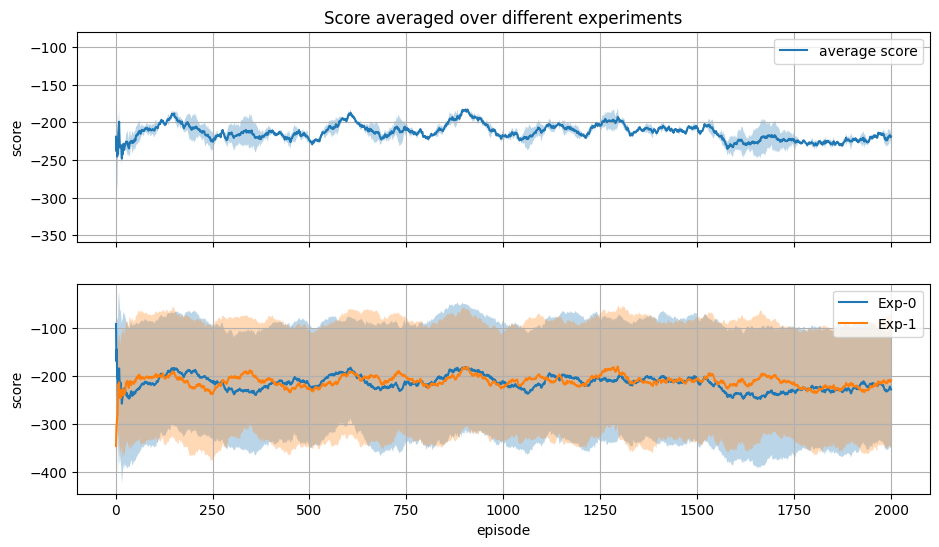

In [71]:
plot_results(avg_scores, std_scores)

In [72]:
# save the random agent results for future comparison
results_data_dict["Random"] = [avg_scores, std_scores]

## REINFORCE with continuous action space
Now we implement the REINFORCE algorithm as it was introduced in the Reinforcement Learning - An Introduction book (Chapter 13.3) in the case of a continuous action space (Chapter 13.7). The REINFORCE algorithm is specified in the figure below
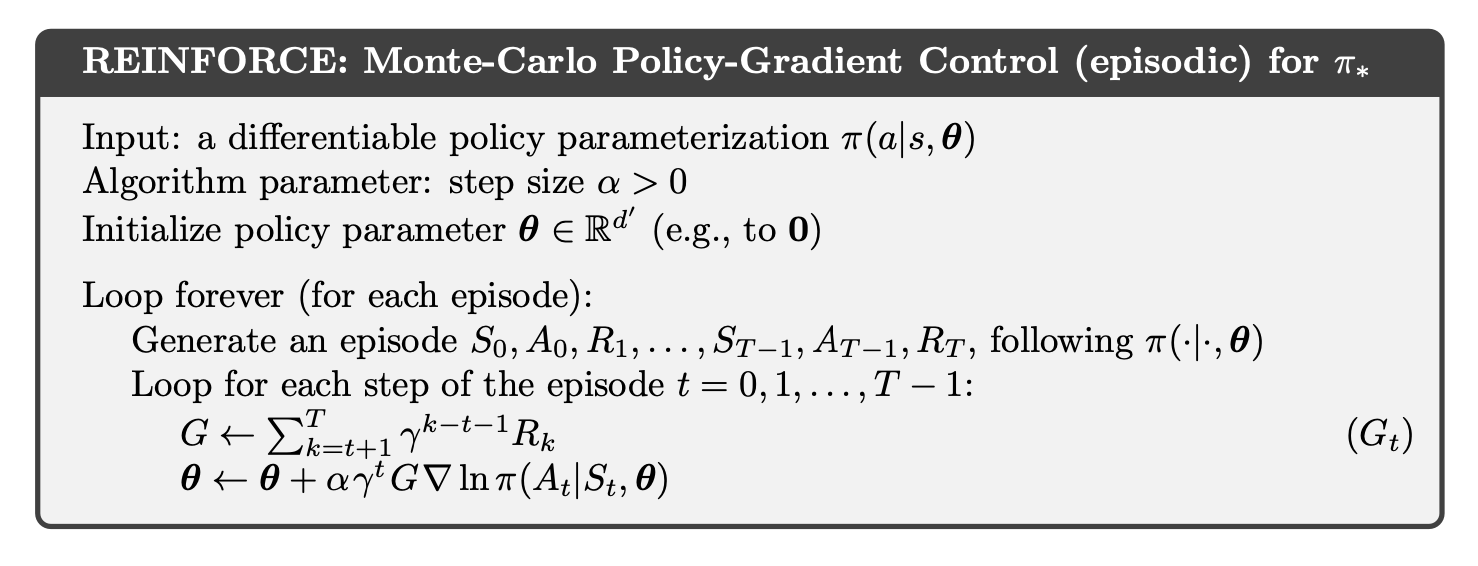

So let's get started

### The Policy Network
For the case of a continuous action space, the policy network doesn't output a vector of probabilities, instead, it outputs the two moments $\mu, \sigma$ of a Gaussian distribution which we then sample for the agent's action.

In [73]:
class PolicyNetwork(nn.Module):
    def __init__(self, observation_dim, action_dim, learning_rate):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=observation_dim, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.mu = nn.Linear(in_features=256, out_features=action_dim)
        self.sigma = nn.Linear(in_features=256, out_features=action_dim)
        
        self.optimizer = T.optim.Adam(params=self.parameters(), lr=learning_rate)
        self.device = ('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        sigma = T.exp(sigma)
        return mu, sigma

Let's check the network's in and out dimensions. 

In [74]:
# init a policy network
policy_net = PolicyNetwork(observation_dim=observation.shape[0], action_dim=action.shape[0], learning_rate=1e-4)

# set an observation batch
observation_batch = np.repeat(np.expand_dims(observation, axis=0), 3, axis=0)

# transform the batch into a torch.Tensor and send it to the network's device
x_in = T.Tensor(observation_batch).float().to(policy_net.device)

# run the feed forward
mu, sigma = policy_net(x_in)

print(f'Policy network input dims: {x_in.size()}')
print(f'Policy network output dims: {mu.size(), sigma.size()}')
print(f'Policy network output:\n{mu}\n{sigma}')

Policy network input dims: torch.Size([3, 8])
Policy network output dims: (torch.Size([3, 2]), torch.Size([3, 2]))
Policy network output:
tensor([[ 0.3395, -0.0075],
        [ 0.3395, -0.0075],
        [ 0.3395, -0.0075]], grad_fn=<AddmmBackward0>)
tensor([[0.9377, 0.9265],
        [0.9377, 0.9265],
        [0.9377, 0.9265]], grad_fn=<ExpBackward0>)


Next, let us create the REINFORCE agent class.

In [82]:
class ReinforceAgent:
    def __init__(self, observation_dim, action_dim, learning_rate, gamma):
        self.lr = learning_rate
        self.gamma = gamma
        
        # initialize policy network
        self.policy = PolicyNetwork(observation_dim=observation_dim, 
                                    action_dim=action_dim, learning_rate=self.lr)
        
        # lists for saving trajectories
        self.rewards = []
        self.log_probs = []
        self.reverse_log_probs = []
        self.returns = []
    
    def reset(self):
        self.rewards = []
        self.log_probs = []
        self.reverse_log_probs = []
        self.returns = []
    
    def choose_action(self, observation):        
        # transform to torch.Tensor and send to device
        observation = T.Tensor(observation).float().to(self.policy.device)
        
        # get the distribution parameters 
        mu, sigma = self.policy(observation)
        
        # create the distribution
        m = T.distributions.Normal(loc=mu, scale=sigma)
        
        # sample an action
        action = m.sample()
        return T.tanh(action).detach().numpy(), m.log_prob(action)
        
    
    def store_transition(self, reward, log_probs):
        self.rewards.append(reward)
        self.log_probs.append(log_probs)
    
    def end_episode_computation(self):
        t = len(self.rewards)
        G = 0
        while t > 0:
            t -= 1
            
            # compute the returns in reversed order
            G = self.rewards[t] + self.gamma * G
            self.returns.append(G)
            self.reverse_log_probs.append(self.log_probs[t])
    
    def learn(self):
        # transform to torch.Tensor and send to device
        log_probs = T.stack(self.reverse_log_probs).float().to(self.policy.device)
        returns = T.Tensor(self.returns).float().unsqueeze(dim=1).to(self.policy.device)
        
        # compute the loss and backpropogate
        self.policy.optimizer.zero_grad()
        loss = T.sum(-returns * log_probs).to(self.policy.device)
        loss.backward()
        self.policy.optimizer.step()

Now we are ready to run a few experiments.

In [91]:
# make the environment
env = gym.make(
        "LunarLander-v2",
        continuous=True,
        gravity=-10.0,
        enable_wind=False,
        wind_power=0.0,
        turbulence_power=0.)

# set hyperparameters
N_EXPERIMENTS = 5
N_EPISODES = 2000
MAX_STEP = 300
GAMMA = 0.99
ACTION_DIM = env.action_space.shape[0]
OBSERVATION_DIM = env.observation_space.shape[0]
LEARNING_RATE = 1e-4

# set empty lists for collecting scores
scores = []
avg_scores = []
std_scores = []

# run the experiments
for ex_i in range(N_EXPERIMENTS):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    agent = ReinforceAgent(observation_dim=OBSERVATION_DIM, 
                           action_dim=ACTION_DIM, 
                           gamma=GAMMA, 
                           learning_rate=LEARNING_RATE)
    
    for ep_i in range(N_EPISODES):
        observation, info = env.reset()
        agent.reset()
        done = False
        score = 0
        step = 0
        
        while not done:
            step += 1
            action, log_prob = agent.choose_action(observation)
            observation_, reward, terminated, truncated, info = env.step(action)
            score += reward
            agent.store_transition(reward, log_prob)
            observation = observation_
            if terminated or truncated or step==MAX_STEP:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
        agent.end_episode_computation()
        agent.learn()
        print(f"| Experiment: {ex_i:3} | Episode: {ep_i:3} | Score: {np.round(score, 2):8.5} | Avg Score: {np.round(avg_scores[ex_i][-1], 2):8.5} |")
env.close()
    

| Experiment:   0 | Episode:   0 | Score:  -127.67 | Avg Score:  -127.67 |
| Experiment:   0 | Episode:   1 | Score:  -144.98 | Avg Score:  -136.32 |
| Experiment:   0 | Episode:   2 | Score:  -462.32 | Avg Score:  -244.99 |
| Experiment:   0 | Episode:   3 | Score:  -410.41 | Avg Score:  -286.34 |
| Experiment:   0 | Episode:   4 | Score:  -419.26 | Avg Score:  -312.93 |
| Experiment:   0 | Episode:   5 | Score:  -111.86 | Avg Score:  -279.42 |
| Experiment:   0 | Episode:   6 | Score:  -103.64 | Avg Score:  -254.31 |
| Experiment:   0 | Episode:   7 | Score:  -157.01 | Avg Score:  -242.14 |
| Experiment:   0 | Episode:   8 | Score:  -382.64 | Avg Score:  -257.75 |
| Experiment:   0 | Episode:   9 | Score:  -427.21 | Avg Score:   -274.7 |
| Experiment:   0 | Episode:  10 | Score:  -328.67 | Avg Score:  -279.61 |
| Experiment:   0 | Episode:  11 | Score:    -98.0 | Avg Score:  -264.47 |
| Experiment:   0 | Episode:  12 | Score:   -15.54 | Avg Score:  -245.32 |
| Experiment:   0 | Episo

| Experiment:   0 | Episode: 114 | Score:  -418.39 | Avg Score:  -214.09 |
| Experiment:   0 | Episode: 115 | Score:   -314.9 | Avg Score:  -216.16 |
| Experiment:   0 | Episode: 116 | Score:   -88.26 | Avg Score:  -213.11 |
| Experiment:   0 | Episode: 117 | Score:  -240.13 | Avg Score:  -211.24 |
| Experiment:   0 | Episode: 118 | Score:   -232.1 | Avg Score:  -212.29 |
| Experiment:   0 | Episode: 119 | Score:  -137.36 | Avg Score:  -210.08 |
| Experiment:   0 | Episode: 120 | Score:  -468.35 | Avg Score:  -212.94 |
| Experiment:   0 | Episode: 121 | Score:  -111.14 | Avg Score:   -210.2 |
| Experiment:   0 | Episode: 122 | Score:  -142.73 | Avg Score:  -208.35 |
| Experiment:   0 | Episode: 123 | Score:   -97.63 | Avg Score:  -207.33 |
| Experiment:   0 | Episode: 124 | Score:  -181.91 | Avg Score:   -205.6 |
| Experiment:   0 | Episode: 125 | Score:  -351.23 | Avg Score:  -206.83 |
| Experiment:   0 | Episode: 126 | Score:  -409.81 | Avg Score:  -209.11 |
| Experiment:   0 | Episo

| Experiment:   0 | Episode: 227 | Score:  -249.19 | Avg Score:  -186.15 |
| Experiment:   0 | Episode: 228 | Score:  -124.75 | Avg Score:  -183.68 |
| Experiment:   0 | Episode: 229 | Score:  -283.03 | Avg Score:  -183.01 |
| Experiment:   0 | Episode: 230 | Score:   -67.86 | Avg Score:  -182.58 |
| Experiment:   0 | Episode: 231 | Score:  -160.45 | Avg Score:  -180.03 |
| Experiment:   0 | Episode: 232 | Score:   -86.94 | Avg Score:  -177.17 |
| Experiment:   0 | Episode: 233 | Score:   -35.04 | Avg Score:  -175.18 |
| Experiment:   0 | Episode: 234 | Score:   -11.16 | Avg Score:  -172.88 |
| Experiment:   0 | Episode: 235 | Score:   -93.72 | Avg Score:   -169.5 |
| Experiment:   0 | Episode: 236 | Score:  -105.22 | Avg Score:   -169.4 |
| Experiment:   0 | Episode: 237 | Score:  -117.29 | Avg Score:  -168.85 |
| Experiment:   0 | Episode: 238 | Score:   -83.79 | Avg Score:  -168.12 |
| Experiment:   0 | Episode: 239 | Score:  -215.29 | Avg Score:  -167.37 |
| Experiment:   0 | Episo

| Experiment:   0 | Episode: 343 | Score:  -109.85 | Avg Score:  -175.16 |
| Experiment:   0 | Episode: 344 | Score:  -111.68 | Avg Score:  -173.03 |
| Experiment:   0 | Episode: 345 | Score:  -312.17 | Avg Score:   -175.0 |
| Experiment:   0 | Episode: 346 | Score:    -66.4 | Avg Score:  -174.32 |
| Experiment:   0 | Episode: 347 | Score:   -25.09 | Avg Score:  -170.81 |
| Experiment:   0 | Episode: 348 | Score:   -85.99 | Avg Score:  -170.27 |
| Experiment:   0 | Episode: 349 | Score:  -103.26 | Avg Score:  -171.03 |
| Experiment:   0 | Episode: 350 | Score:  -198.55 | Avg Score:  -171.97 |
| Experiment:   0 | Episode: 351 | Score:  -227.03 | Avg Score:  -173.41 |
| Experiment:   0 | Episode: 352 | Score:   -46.21 | Avg Score:   -173.3 |
| Experiment:   0 | Episode: 353 | Score:  -495.09 | Avg Score:  -177.63 |
| Experiment:   0 | Episode: 354 | Score:   -49.42 | Avg Score:  -176.63 |
| Experiment:   0 | Episode: 355 | Score:  -146.01 | Avg Score:  -176.29 |
| Experiment:   0 | Episo

| Experiment:   0 | Episode: 457 | Score:  -206.24 | Avg Score:   -129.0 |
| Experiment:   0 | Episode: 458 | Score:  -157.65 | Avg Score:  -130.11 |
| Experiment:   0 | Episode: 459 | Score:  -155.64 | Avg Score:  -130.58 |
| Experiment:   0 | Episode: 460 | Score:  -224.49 | Avg Score:  -131.39 |
| Experiment:   0 | Episode: 461 | Score:  -116.54 | Avg Score:  -131.93 |
| Experiment:   0 | Episode: 462 | Score:   -86.45 | Avg Score:  -131.71 |
| Experiment:   0 | Episode: 463 | Score:   -71.14 | Avg Score:  -131.09 |
| Experiment:   0 | Episode: 464 | Score:  -287.01 | Avg Score:  -133.96 |
| Experiment:   0 | Episode: 465 | Score:  -265.87 | Avg Score:  -135.07 |
| Experiment:   0 | Episode: 466 | Score:   -48.02 | Avg Score:  -134.58 |
| Experiment:   0 | Episode: 467 | Score:  -100.13 | Avg Score:  -134.99 |
| Experiment:   0 | Episode: 468 | Score:  -108.51 | Avg Score:  -134.82 |
| Experiment:   0 | Episode: 469 | Score:  -222.78 | Avg Score:  -136.34 |
| Experiment:   0 | Episo

| Experiment:   0 | Episode: 568 | Score:   -89.04 | Avg Score:  -137.14 |
| Experiment:   0 | Episode: 569 | Score:    -95.0 | Avg Score:  -135.86 |
| Experiment:   0 | Episode: 570 | Score:   -47.03 | Avg Score:  -135.48 |
| Experiment:   0 | Episode: 571 | Score:  -172.47 | Avg Score:  -136.33 |
| Experiment:   0 | Episode: 572 | Score:  -133.36 | Avg Score:  -137.03 |
| Experiment:   0 | Episode: 573 | Score:   -167.2 | Avg Score:  -136.95 |
| Experiment:   0 | Episode: 574 | Score:   -93.68 | Avg Score:  -136.86 |
| Experiment:   0 | Episode: 575 | Score:  -190.66 | Avg Score:  -137.54 |
| Experiment:   0 | Episode: 576 | Score:   -55.56 | Avg Score:  -137.21 |
| Experiment:   0 | Episode: 577 | Score:  -172.17 | Avg Score:  -137.89 |
| Experiment:   0 | Episode: 578 | Score:    25.56 | Avg Score:  -136.68 |
| Experiment:   0 | Episode: 579 | Score:  -118.76 | Avg Score:  -137.28 |
| Experiment:   0 | Episode: 580 | Score:  -184.42 | Avg Score:   -137.5 |
| Experiment:   0 | Episo

| Experiment:   0 | Episode: 680 | Score:   -46.84 | Avg Score:  -146.46 |
| Experiment:   0 | Episode: 681 | Score:  -137.69 | Avg Score:  -147.19 |
| Experiment:   0 | Episode: 682 | Score:   -78.37 | Avg Score:  -146.11 |
| Experiment:   0 | Episode: 683 | Score:  -249.36 | Avg Score:  -147.33 |
| Experiment:   0 | Episode: 684 | Score:   -99.09 | Avg Score:  -147.57 |
| Experiment:   0 | Episode: 685 | Score:  -157.72 | Avg Score:   -147.3 |
| Experiment:   0 | Episode: 686 | Score:  -177.27 | Avg Score:  -146.58 |
| Experiment:   0 | Episode: 687 | Score:   -93.94 | Avg Score:  -146.51 |
| Experiment:   0 | Episode: 688 | Score:   -30.41 | Avg Score:  -146.22 |
| Experiment:   0 | Episode: 689 | Score:  -165.32 | Avg Score:  -146.74 |
| Experiment:   0 | Episode: 690 | Score:  -115.92 | Avg Score:  -147.48 |
| Experiment:   0 | Episode: 691 | Score:   -81.84 | Avg Score:  -147.86 |
| Experiment:   0 | Episode: 692 | Score:   -37.51 | Avg Score:  -146.96 |
| Experiment:   0 | Episo

| Experiment:   0 | Episode: 795 | Score:   -73.44 | Avg Score:  -103.02 |
| Experiment:   0 | Episode: 796 | Score:  -123.74 | Avg Score:  -103.52 |
| Experiment:   0 | Episode: 797 | Score:   -45.76 | Avg Score:  -102.06 |
| Experiment:   0 | Episode: 798 | Score:   -74.78 | Avg Score:  -100.46 |
| Experiment:   0 | Episode: 799 | Score:   -87.15 | Avg Score:  -100.47 |
| Experiment:   0 | Episode: 800 | Score:   -74.06 | Avg Score:  -100.52 |
| Experiment:   0 | Episode: 801 | Score:   -56.22 | Avg Score:   -99.76 |
| Experiment:   0 | Episode: 802 | Score:   -57.35 | Avg Score:   -99.91 |
| Experiment:   0 | Episode: 803 | Score:   -50.02 | Avg Score:    -99.3 |
| Experiment:   0 | Episode: 804 | Score:   -97.49 | Avg Score:   -98.29 |
| Experiment:   0 | Episode: 805 | Score:  -147.78 | Avg Score:   -99.06 |
| Experiment:   0 | Episode: 806 | Score:  -134.76 | Avg Score:   -99.57 |
| Experiment:   0 | Episode: 807 | Score:   -20.88 | Avg Score:   -98.99 |
| Experiment:   0 | Episo

| Experiment:   0 | Episode: 909 | Score:    -58.7 | Avg Score:  -111.54 |
| Experiment:   0 | Episode: 910 | Score:   -35.91 | Avg Score:  -109.79 |
| Experiment:   0 | Episode: 911 | Score:  -110.89 | Avg Score:  -110.29 |
| Experiment:   0 | Episode: 912 | Score:   -88.86 | Avg Score:   -109.8 |
| Experiment:   0 | Episode: 913 | Score:    -71.5 | Avg Score:  -108.84 |
| Experiment:   0 | Episode: 914 | Score:   -60.19 | Avg Score:  -107.81 |
| Experiment:   0 | Episode: 915 | Score:  -196.35 | Avg Score:  -108.94 |
| Experiment:   0 | Episode: 916 | Score:  -200.37 | Avg Score:  -109.95 |
| Experiment:   0 | Episode: 917 | Score:  -104.16 | Avg Score:  -110.07 |
| Experiment:   0 | Episode: 918 | Score:   -125.4 | Avg Score:  -110.21 |
| Experiment:   0 | Episode: 919 | Score:   -37.31 | Avg Score:  -109.91 |
| Experiment:   0 | Episode: 920 | Score:  -156.64 | Avg Score:  -110.32 |
| Experiment:   0 | Episode: 921 | Score:   -64.09 | Avg Score:  -110.08 |
| Experiment:   0 | Episo

| Experiment:   0 | Episode: 1019 | Score:   -76.57 | Avg Score:   -97.18 |
| Experiment:   0 | Episode: 1020 | Score:  -118.89 | Avg Score:    -96.8 |
| Experiment:   0 | Episode: 1021 | Score:   -176.9 | Avg Score:   -97.93 |
| Experiment:   0 | Episode: 1022 | Score:   -84.66 | Avg Score:   -97.97 |
| Experiment:   0 | Episode: 1023 | Score:   -38.52 | Avg Score:   -97.46 |
| Experiment:   0 | Episode: 1024 | Score:   -65.81 | Avg Score:   -97.37 |
| Experiment:   0 | Episode: 1025 | Score:   -69.48 | Avg Score:   -94.95 |
| Experiment:   0 | Episode: 1026 | Score:    -53.3 | Avg Score:   -93.37 |
| Experiment:   0 | Episode: 1027 | Score:  -127.63 | Avg Score:   -94.06 |
| Experiment:   0 | Episode: 1028 | Score:   -76.43 | Avg Score:    -92.4 |
| Experiment:   0 | Episode: 1029 | Score:  -141.48 | Avg Score:   -93.12 |
| Experiment:   0 | Episode: 1030 | Score:  -116.68 | Avg Score:   -93.39 |
| Experiment:   0 | Episode: 1031 | Score:  -232.78 | Avg Score:   -94.58 |
| Experiment

| Experiment:   0 | Episode: 1130 | Score:   -62.86 | Avg Score:  -101.68 |
| Experiment:   0 | Episode: 1131 | Score:  -124.17 | Avg Score:  -100.59 |
| Experiment:   0 | Episode: 1132 | Score:  -107.03 | Avg Score:  -100.62 |
| Experiment:   0 | Episode: 1133 | Score:   -97.08 | Avg Score:   -99.87 |
| Experiment:   0 | Episode: 1134 | Score:  -226.69 | Avg Score:  -101.42 |
| Experiment:   0 | Episode: 1135 | Score:  -182.85 | Avg Score:  -102.67 |
| Experiment:   0 | Episode: 1136 | Score:  -119.25 | Avg Score:  -102.98 |
| Experiment:   0 | Episode: 1137 | Score:   -256.0 | Avg Score:  -104.64 |
| Experiment:   0 | Episode: 1138 | Score:   -21.23 | Avg Score:  -103.98 |
| Experiment:   0 | Episode: 1139 | Score:   -75.79 | Avg Score:  -104.27 |
| Experiment:   0 | Episode: 1140 | Score:  -181.42 | Avg Score:  -105.41 |
| Experiment:   0 | Episode: 1141 | Score:  -111.57 | Avg Score:  -105.95 |
| Experiment:   0 | Episode: 1142 | Score:   -52.09 | Avg Score:  -105.97 |
| Experiment

| Experiment:   0 | Episode: 1241 | Score:   -109.8 | Avg Score:   -94.71 |
| Experiment:   0 | Episode: 1242 | Score:   -55.82 | Avg Score:   -94.75 |
| Experiment:   0 | Episode: 1243 | Score:  -108.71 | Avg Score:   -95.84 |
| Experiment:   0 | Episode: 1244 | Score:  -153.31 | Avg Score:   -96.74 |
| Experiment:   0 | Episode: 1245 | Score:   -40.95 | Avg Score:   -96.13 |
| Experiment:   0 | Episode: 1246 | Score:  -113.83 | Avg Score:    -95.2 |
| Experiment:   0 | Episode: 1247 | Score:   -96.48 | Avg Score:   -95.17 |
| Experiment:   0 | Episode: 1248 | Score:  -204.47 | Avg Score:   -95.97 |
| Experiment:   0 | Episode: 1249 | Score:   -79.19 | Avg Score:   -95.42 |
| Experiment:   0 | Episode: 1250 | Score:  -150.96 | Avg Score:   -96.09 |
| Experiment:   0 | Episode: 1251 | Score:   -46.72 | Avg Score:   -96.75 |
| Experiment:   0 | Episode: 1252 | Score:   -94.12 | Avg Score:   -95.95 |
| Experiment:   0 | Episode: 1253 | Score:   -89.48 | Avg Score:   -96.28 |
| Experiment

| Experiment:   0 | Episode: 1349 | Score:   -109.1 | Avg Score:    -95.7 |
| Experiment:   0 | Episode: 1350 | Score:   -19.77 | Avg Score:   -94.39 |
| Experiment:   0 | Episode: 1351 | Score:   -25.41 | Avg Score:   -94.18 |
| Experiment:   0 | Episode: 1352 | Score:    -95.1 | Avg Score:   -94.19 |
| Experiment:   0 | Episode: 1353 | Score:  -132.01 | Avg Score:   -94.61 |
| Experiment:   0 | Episode: 1354 | Score:  -167.04 | Avg Score:   -96.06 |
| Experiment:   0 | Episode: 1355 | Score:   -64.91 | Avg Score:   -95.94 |
| Experiment:   0 | Episode: 1356 | Score:   -40.83 | Avg Score:   -95.81 |
| Experiment:   0 | Episode: 1357 | Score:   -70.32 | Avg Score:   -95.91 |
| Experiment:   0 | Episode: 1358 | Score:    -12.2 | Avg Score:   -94.75 |
| Experiment:   0 | Episode: 1359 | Score:   -36.68 | Avg Score:   -93.85 |
| Experiment:   0 | Episode: 1360 | Score:   -74.25 | Avg Score:   -93.24 |
| Experiment:   0 | Episode: 1361 | Score:     -2.3 | Avg Score:   -92.89 |
| Experiment

| Experiment:   0 | Episode: 1458 | Score:  -117.22 | Avg Score:   -89.35 |
| Experiment:   0 | Episode: 1459 | Score:   -63.83 | Avg Score:   -89.62 |
| Experiment:   0 | Episode: 1460 | Score:   -74.42 | Avg Score:   -89.62 |
| Experiment:   0 | Episode: 1461 | Score:   -31.26 | Avg Score:   -89.91 |
| Experiment:   0 | Episode: 1462 | Score:     -0.7 | Avg Score:   -88.41 |
| Experiment:   0 | Episode: 1463 | Score:   -61.09 | Avg Score:   -88.21 |
| Experiment:   0 | Episode: 1464 | Score:   -65.64 | Avg Score:   -87.76 |
| Experiment:   0 | Episode: 1465 | Score:   -34.24 | Avg Score:   -87.78 |
| Experiment:   0 | Episode: 1466 | Score:     1.38 | Avg Score:   -87.34 |
| Experiment:   0 | Episode: 1467 | Score:   -63.24 | Avg Score:   -87.64 |
| Experiment:   0 | Episode: 1468 | Score:   -20.99 | Avg Score:   -85.11 |
| Experiment:   0 | Episode: 1469 | Score:   -73.49 | Avg Score:   -85.38 |
| Experiment:   0 | Episode: 1470 | Score:   -87.41 | Avg Score:   -84.64 |
| Experiment

| Experiment:   0 | Episode: 1568 | Score:  -132.09 | Avg Score:   -65.48 |
| Experiment:   0 | Episode: 1569 | Score:   -52.36 | Avg Score:   -65.27 |
| Experiment:   0 | Episode: 1570 | Score:  -184.26 | Avg Score:   -66.24 |
| Experiment:   0 | Episode: 1571 | Score:  -163.85 | Avg Score:   -66.91 |
| Experiment:   0 | Episode: 1572 | Score:   -57.27 | Avg Score:   -66.95 |
| Experiment:   0 | Episode: 1573 | Score:   -56.53 | Avg Score:   -66.96 |
| Experiment:   0 | Episode: 1574 | Score:   -35.89 | Avg Score:   -67.29 |
| Experiment:   0 | Episode: 1575 | Score:   -37.14 | Avg Score:   -67.13 |
| Experiment:   0 | Episode: 1576 | Score:  -150.72 | Avg Score:   -68.61 |
| Experiment:   0 | Episode: 1577 | Score:   -75.48 | Avg Score:    -68.4 |
| Experiment:   0 | Episode: 1578 | Score:   -32.37 | Avg Score:   -68.01 |
| Experiment:   0 | Episode: 1579 | Score:  -151.59 | Avg Score:   -68.63 |
| Experiment:   0 | Episode: 1580 | Score:   -54.64 | Avg Score:   -69.15 |
| Experiment

| Experiment:   0 | Episode: 1680 | Score:   -89.25 | Avg Score:   -79.95 |
| Experiment:   0 | Episode: 1681 | Score:   -42.23 | Avg Score:   -80.02 |
| Experiment:   0 | Episode: 1682 | Score:   -89.02 | Avg Score:   -78.05 |
| Experiment:   0 | Episode: 1683 | Score:   -85.45 | Avg Score:   -78.79 |
| Experiment:   0 | Episode: 1684 | Score:   -64.28 | Avg Score:   -79.14 |
| Experiment:   0 | Episode: 1685 | Score:  -146.27 | Avg Score:   -76.12 |
| Experiment:   0 | Episode: 1686 | Score:   -68.73 | Avg Score:   -75.86 |
| Experiment:   0 | Episode: 1687 | Score:   -63.65 | Avg Score:   -75.57 |
| Experiment:   0 | Episode: 1688 | Score:    18.57 | Avg Score:   -75.22 |
| Experiment:   0 | Episode: 1689 | Score:    28.18 | Avg Score:   -74.37 |
| Experiment:   0 | Episode: 1690 | Score:   -32.61 | Avg Score:   -73.21 |
| Experiment:   0 | Episode: 1691 | Score:    -68.4 | Avg Score:   -73.55 |
| Experiment:   0 | Episode: 1692 | Score:    13.91 | Avg Score:   -73.13 |
| Experiment

| Experiment:   0 | Episode: 1791 | Score:   -59.22 | Avg Score:   -66.55 |
| Experiment:   0 | Episode: 1792 | Score:  -228.03 | Avg Score:   -68.97 |
| Experiment:   0 | Episode: 1793 | Score:    13.05 | Avg Score:   -68.71 |
| Experiment:   0 | Episode: 1794 | Score:    79.16 | Avg Score:   -67.24 |
| Experiment:   0 | Episode: 1795 | Score:     33.0 | Avg Score:   -66.72 |
| Experiment:   0 | Episode: 1796 | Score:   -18.86 | Avg Score:   -66.71 |
| Experiment:   0 | Episode: 1797 | Score:   -32.95 | Avg Score:   -66.34 |
| Experiment:   0 | Episode: 1798 | Score:   -153.4 | Avg Score:   -66.51 |
| Experiment:   0 | Episode: 1799 | Score:     4.76 | Avg Score:   -66.56 |
| Experiment:   0 | Episode: 1800 | Score:   -93.84 | Avg Score:   -66.82 |
| Experiment:   0 | Episode: 1801 | Score:   -62.35 | Avg Score:   -67.06 |
| Experiment:   0 | Episode: 1802 | Score:    -0.84 | Avg Score:   -66.09 |
| Experiment:   0 | Episode: 1803 | Score:   -10.51 | Avg Score:   -64.97 |
| Experiment

| Experiment:   0 | Episode: 1899 | Score:   -50.12 | Avg Score:   -72.32 |
| Experiment:   0 | Episode: 1900 | Score:   -89.41 | Avg Score:   -72.27 |
| Experiment:   0 | Episode: 1901 | Score:   -61.85 | Avg Score:   -72.27 |
| Experiment:   0 | Episode: 1902 | Score:   -56.75 | Avg Score:   -72.83 |
| Experiment:   0 | Episode: 1903 | Score:   -38.49 | Avg Score:   -73.11 |
| Experiment:   0 | Episode: 1904 | Score:     -7.0 | Avg Score:   -70.78 |
| Experiment:   0 | Episode: 1905 | Score:   -55.69 | Avg Score:   -69.91 |
| Experiment:   0 | Episode: 1906 | Score:   -51.54 | Avg Score:   -68.42 |
| Experiment:   0 | Episode: 1907 | Score:   -70.44 | Avg Score:   -68.93 |
| Experiment:   0 | Episode: 1908 | Score:    -69.7 | Avg Score:    -69.0 |
| Experiment:   0 | Episode: 1909 | Score:   -65.15 | Avg Score:   -67.18 |
| Experiment:   0 | Episode: 1910 | Score:    -47.4 | Avg Score:   -63.11 |
| Experiment:   0 | Episode: 1911 | Score:   -62.33 | Avg Score:   -63.21 |
| Experiment

| Experiment:   1 | Episode:   9 | Score:  -124.67 | Avg Score:  -175.18 |
| Experiment:   1 | Episode:  10 | Score:   -42.62 | Avg Score:  -163.12 |
| Experiment:   1 | Episode:  11 | Score:   -75.41 | Avg Score:  -155.82 |
| Experiment:   1 | Episode:  12 | Score:  -183.67 | Avg Score:  -157.96 |
| Experiment:   1 | Episode:  13 | Score:  -408.08 | Avg Score:  -175.82 |
| Experiment:   1 | Episode:  14 | Score:  -395.95 | Avg Score:   -190.5 |
| Experiment:   1 | Episode:  15 | Score:  -474.26 | Avg Score:  -208.23 |
| Experiment:   1 | Episode:  16 | Score:  -315.23 | Avg Score:  -214.53 |
| Experiment:   1 | Episode:  17 | Score:   -388.2 | Avg Score:  -224.18 |
| Experiment:   1 | Episode:  18 | Score:  -301.59 | Avg Score:  -228.25 |
| Experiment:   1 | Episode:  19 | Score:  -294.33 | Avg Score:  -231.55 |
| Experiment:   1 | Episode:  20 | Score:  -333.91 | Avg Score:  -236.43 |
| Experiment:   1 | Episode:  21 | Score:  -180.34 | Avg Score:  -233.88 |
| Experiment:   1 | Episo

| Experiment:   1 | Episode: 121 | Score:  -204.23 | Avg Score:  -191.76 |
| Experiment:   1 | Episode: 122 | Score:  -169.81 | Avg Score:  -189.05 |
| Experiment:   1 | Episode: 123 | Score:  -237.57 | Avg Score:  -188.61 |
| Experiment:   1 | Episode: 124 | Score:  -113.24 | Avg Score:  -185.43 |
| Experiment:   1 | Episode: 125 | Score:  -289.67 | Avg Score:  -183.28 |
| Experiment:   1 | Episode: 126 | Score:  -164.22 | Avg Score:   -181.1 |
| Experiment:   1 | Episode: 127 | Score:   -99.88 | Avg Score:   -178.3 |
| Experiment:   1 | Episode: 128 | Score:  -335.09 | Avg Score:  -180.52 |
| Experiment:   1 | Episode: 129 | Score:   -35.72 | Avg Score:  -178.21 |
| Experiment:   1 | Episode: 130 | Score:   -93.71 | Avg Score:  -177.79 |
| Experiment:   1 | Episode: 131 | Score:  -135.63 | Avg Score:  -173.26 |
| Experiment:   1 | Episode: 132 | Score:  -140.62 | Avg Score:  -171.72 |
| Experiment:   1 | Episode: 133 | Score:  -291.25 | Avg Score:  -170.06 |
| Experiment:   1 | Episo

| Experiment:   1 | Episode: 235 | Score:  -118.09 | Avg Score:  -192.09 |
| Experiment:   1 | Episode: 236 | Score:  -121.96 | Avg Score:  -189.95 |
| Experiment:   1 | Episode: 237 | Score:  -199.25 | Avg Score:   -190.7 |
| Experiment:   1 | Episode: 238 | Score:  -179.24 | Avg Score:  -191.22 |
| Experiment:   1 | Episode: 239 | Score:  -113.34 | Avg Score:  -189.02 |
| Experiment:   1 | Episode: 240 | Score:  -174.87 | Avg Score:  -189.32 |
| Experiment:   1 | Episode: 241 | Score:   -89.65 | Avg Score:  -189.87 |
| Experiment:   1 | Episode: 242 | Score:  -130.84 | Avg Score:  -188.65 |
| Experiment:   1 | Episode: 243 | Score:   -92.35 | Avg Score:  -188.56 |
| Experiment:   1 | Episode: 244 | Score:   -37.27 | Avg Score:  -187.59 |
| Experiment:   1 | Episode: 245 | Score:  -317.29 | Avg Score:  -188.09 |
| Experiment:   1 | Episode: 246 | Score:   -84.53 | Avg Score:  -188.06 |
| Experiment:   1 | Episode: 247 | Score:  -135.07 | Avg Score:   -188.8 |
| Experiment:   1 | Episo

| Experiment:   1 | Episode: 349 | Score:   -213.1 | Avg Score:  -157.42 |
| Experiment:   1 | Episode: 350 | Score:   -67.72 | Avg Score:  -156.55 |
| Experiment:   1 | Episode: 351 | Score:   -78.44 | Avg Score:  -154.81 |
| Experiment:   1 | Episode: 352 | Score:   -97.94 | Avg Score:  -151.99 |
| Experiment:   1 | Episode: 353 | Score:  -188.64 | Avg Score:  -150.59 |
| Experiment:   1 | Episode: 354 | Score:  -199.76 | Avg Score:  -149.97 |
| Experiment:   1 | Episode: 355 | Score:  -293.53 | Avg Score:  -148.46 |
| Experiment:   1 | Episode: 356 | Score:  -115.97 | Avg Score:  -148.62 |
| Experiment:   1 | Episode: 357 | Score:  -277.27 | Avg Score:  -150.44 |
| Experiment:   1 | Episode: 358 | Score:  -212.96 | Avg Score:  -150.59 |
| Experiment:   1 | Episode: 359 | Score:  -134.56 | Avg Score:   -150.4 |
| Experiment:   1 | Episode: 360 | Score:  -102.71 | Avg Score:  -149.58 |
| Experiment:   1 | Episode: 361 | Score:  -118.97 | Avg Score:  -148.73 |
| Experiment:   1 | Episo

| Experiment:   1 | Episode: 464 | Score:   -87.55 | Avg Score:  -147.93 |
| Experiment:   1 | Episode: 465 | Score:  -220.74 | Avg Score:  -149.22 |
| Experiment:   1 | Episode: 466 | Score:  -326.92 | Avg Score:  -149.62 |
| Experiment:   1 | Episode: 467 | Score:  -220.82 | Avg Score:  -151.02 |
| Experiment:   1 | Episode: 468 | Score:  -170.78 | Avg Score:  -150.75 |
| Experiment:   1 | Episode: 469 | Score:  -129.74 | Avg Score:  -150.31 |
| Experiment:   1 | Episode: 470 | Score:   -84.16 | Avg Score:  -149.63 |
| Experiment:   1 | Episode: 471 | Score:  -104.38 | Avg Score:  -149.79 |
| Experiment:   1 | Episode: 472 | Score:  -348.89 | Avg Score:   -152.6 |
| Experiment:   1 | Episode: 473 | Score:   -74.55 | Avg Score:  -152.11 |
| Experiment:   1 | Episode: 474 | Score:   -74.69 | Avg Score:  -151.96 |
| Experiment:   1 | Episode: 475 | Score:  -124.85 | Avg Score:  -152.02 |
| Experiment:   1 | Episode: 476 | Score:  -103.19 | Avg Score:  -152.23 |
| Experiment:   1 | Episo

| Experiment:   1 | Episode: 579 | Score:   -87.13 | Avg Score:  -147.05 |
| Experiment:   1 | Episode: 580 | Score:  -389.18 | Avg Score:  -150.23 |
| Experiment:   1 | Episode: 581 | Score:  -147.27 | Avg Score:  -151.16 |
| Experiment:   1 | Episode: 582 | Score:  -168.49 | Avg Score:  -151.69 |
| Experiment:   1 | Episode: 583 | Score:  -102.54 | Avg Score:  -151.27 |
| Experiment:   1 | Episode: 584 | Score:  -171.84 | Avg Score:  -152.66 |
| Experiment:   1 | Episode: 585 | Score:   -13.23 | Avg Score:  -150.13 |
| Experiment:   1 | Episode: 586 | Score:  -237.65 | Avg Score:  -151.96 |
| Experiment:   1 | Episode: 587 | Score:   -78.06 | Avg Score:  -151.07 |
| Experiment:   1 | Episode: 588 | Score:  -218.41 | Avg Score:  -152.33 |
| Experiment:   1 | Episode: 589 | Score:  -357.46 | Avg Score:  -154.77 |
| Experiment:   1 | Episode: 590 | Score:  -100.73 | Avg Score:  -154.99 |
| Experiment:   1 | Episode: 591 | Score:  -122.87 | Avg Score:  -155.68 |
| Experiment:   1 | Episo

| Experiment:   1 | Episode: 689 | Score:   -73.95 | Avg Score:  -127.75 |
| Experiment:   1 | Episode: 690 | Score:    -83.3 | Avg Score:  -127.57 |
| Experiment:   1 | Episode: 691 | Score:  -127.99 | Avg Score:  -127.62 |
| Experiment:   1 | Episode: 692 | Score:   -89.47 | Avg Score:  -127.28 |
| Experiment:   1 | Episode: 693 | Score:   -61.79 | Avg Score:  -126.91 |
| Experiment:   1 | Episode: 694 | Score:   -162.2 | Avg Score:  -127.61 |
| Experiment:   1 | Episode: 695 | Score:  -263.23 | Avg Score:  -128.34 |
| Experiment:   1 | Episode: 696 | Score:  -166.08 | Avg Score:   -128.0 |
| Experiment:   1 | Episode: 697 | Score:  -163.28 | Avg Score:  -126.66 |
| Experiment:   1 | Episode: 698 | Score:  -278.61 | Avg Score:  -128.78 |
| Experiment:   1 | Episode: 699 | Score:    -98.6 | Avg Score:  -128.28 |
| Experiment:   1 | Episode: 700 | Score:  -121.64 | Avg Score:  -126.98 |
| Experiment:   1 | Episode: 701 | Score:   -82.26 | Avg Score:  -126.53 |
| Experiment:   1 | Episo

| Experiment:   1 | Episode: 803 | Score:  -141.51 | Avg Score:  -140.45 |
| Experiment:   1 | Episode: 804 | Score:  -238.88 | Avg Score:  -139.13 |
| Experiment:   1 | Episode: 805 | Score:  -106.16 | Avg Score:   -137.6 |
| Experiment:   1 | Episode: 806 | Score:   -80.38 | Avg Score:  -137.64 |
| Experiment:   1 | Episode: 807 | Score:   -76.41 | Avg Score:  -136.99 |
| Experiment:   1 | Episode: 808 | Score:  -217.74 | Avg Score:  -137.17 |
| Experiment:   1 | Episode: 809 | Score:   -90.36 | Avg Score:   -136.7 |
| Experiment:   1 | Episode: 810 | Score:  -125.83 | Avg Score:  -137.39 |
| Experiment:   1 | Episode: 811 | Score:  -112.98 | Avg Score:  -137.75 |
| Experiment:   1 | Episode: 812 | Score:   -91.25 | Avg Score:  -136.74 |
| Experiment:   1 | Episode: 813 | Score:    13.49 | Avg Score:  -135.57 |
| Experiment:   1 | Episode: 814 | Score:  -198.14 | Avg Score:  -136.87 |
| Experiment:   1 | Episode: 815 | Score:   -72.81 | Avg Score:  -135.84 |
| Experiment:   1 | Episo

| Experiment:   1 | Episode: 913 | Score:   -78.54 | Avg Score:   -136.2 |
| Experiment:   1 | Episode: 914 | Score:   -171.5 | Avg Score:  -135.93 |
| Experiment:   1 | Episode: 915 | Score:  -151.96 | Avg Score:  -136.72 |
| Experiment:   1 | Episode: 916 | Score:   -71.94 | Avg Score:  -136.22 |
| Experiment:   1 | Episode: 917 | Score:   -77.47 | Avg Score:  -136.14 |
| Experiment:   1 | Episode: 918 | Score:  -231.29 | Avg Score:  -136.38 |
| Experiment:   1 | Episode: 919 | Score:  -121.87 | Avg Score:  -136.74 |
| Experiment:   1 | Episode: 920 | Score:  -342.17 | Avg Score:  -138.87 |
| Experiment:   1 | Episode: 921 | Score:  -114.39 | Avg Score:  -138.79 |
| Experiment:   1 | Episode: 922 | Score:   -14.53 | Avg Score:  -138.57 |
| Experiment:   1 | Episode: 923 | Score:   -93.83 | Avg Score:  -137.16 |
| Experiment:   1 | Episode: 924 | Score:  -225.26 | Avg Score:  -138.29 |
| Experiment:   1 | Episode: 925 | Score:   -76.84 | Avg Score:  -137.66 |
| Experiment:   1 | Episo

| Experiment:   1 | Episode: 1022 | Score:  -145.91 | Avg Score:  -127.75 |
| Experiment:   1 | Episode: 1023 | Score:  -122.22 | Avg Score:  -128.03 |
| Experiment:   1 | Episode: 1024 | Score:   -77.27 | Avg Score:  -126.55 |
| Experiment:   1 | Episode: 1025 | Score:   -88.16 | Avg Score:  -126.66 |
| Experiment:   1 | Episode: 1026 | Score:  -106.02 | Avg Score:  -125.95 |
| Experiment:   1 | Episode: 1027 | Score:  -290.67 | Avg Score:  -126.86 |
| Experiment:   1 | Episode: 1028 | Score:   -69.11 | Avg Score:  -125.96 |
| Experiment:   1 | Episode: 1029 | Score:   -38.09 | Avg Score:   -125.9 |
| Experiment:   1 | Episode: 1030 | Score:   -82.33 | Avg Score:  -125.92 |
| Experiment:   1 | Episode: 1031 | Score:  -106.74 | Avg Score:  -124.89 |
| Experiment:   1 | Episode: 1032 | Score:  -310.71 | Avg Score:  -128.99 |
| Experiment:   1 | Episode: 1033 | Score:  -102.14 | Avg Score:  -128.97 |
| Experiment:   1 | Episode: 1034 | Score:   -58.19 | Avg Score:   -128.6 |
| Experiment

| Experiment:   1 | Episode: 1131 | Score:  -140.19 | Avg Score:  -115.83 |
| Experiment:   1 | Episode: 1132 | Score:   -89.03 | Avg Score:  -113.61 |
| Experiment:   1 | Episode: 1133 | Score:   -73.69 | Avg Score:  -113.33 |
| Experiment:   1 | Episode: 1134 | Score:  -101.83 | Avg Score:  -113.77 |
| Experiment:   1 | Episode: 1135 | Score:   -55.04 | Avg Score:  -113.47 |
| Experiment:   1 | Episode: 1136 | Score:  -141.61 | Avg Score:  -114.06 |
| Experiment:   1 | Episode: 1137 | Score:  -118.94 | Avg Score:  -113.02 |
| Experiment:   1 | Episode: 1138 | Score:   -31.54 | Avg Score:  -111.33 |
| Experiment:   1 | Episode: 1139 | Score:   -155.5 | Avg Score:   -111.5 |
| Experiment:   1 | Episode: 1140 | Score:  -100.55 | Avg Score:  -111.81 |
| Experiment:   1 | Episode: 1141 | Score:   -77.05 | Avg Score:  -111.36 |
| Experiment:   1 | Episode: 1142 | Score:  -105.45 | Avg Score:   -111.0 |
| Experiment:   1 | Episode: 1143 | Score:   -52.56 | Avg Score:  -110.59 |
| Experiment

| Experiment:   1 | Episode: 1244 | Score:   -81.83 | Avg Score:  -102.75 |
| Experiment:   1 | Episode: 1245 | Score:   -81.72 | Avg Score:  -102.53 |
| Experiment:   1 | Episode: 1246 | Score:   -73.54 | Avg Score:  -101.41 |
| Experiment:   1 | Episode: 1247 | Score:   -60.23 | Avg Score:  -100.27 |
| Experiment:   1 | Episode: 1248 | Score:  -145.51 | Avg Score:  -100.78 |
| Experiment:   1 | Episode: 1249 | Score:   -89.86 | Avg Score:  -100.74 |
| Experiment:   1 | Episode: 1250 | Score:  -173.38 | Avg Score:  -100.23 |
| Experiment:   1 | Episode: 1251 | Score:  -114.74 | Avg Score:  -100.86 |
| Experiment:   1 | Episode: 1252 | Score:  -137.44 | Avg Score:  -101.36 |
| Experiment:   1 | Episode: 1253 | Score:  -222.63 | Avg Score:  -102.68 |
| Experiment:   1 | Episode: 1254 | Score:  -107.46 | Avg Score:  -103.08 |
| Experiment:   1 | Episode: 1255 | Score:   -90.23 | Avg Score:  -103.16 |
| Experiment:   1 | Episode: 1256 | Score:    21.59 | Avg Score:  -102.13 |
| Experiment

| Experiment:   1 | Episode: 1355 | Score:   -74.37 | Avg Score:  -110.41 |
| Experiment:   1 | Episode: 1356 | Score:  -206.87 | Avg Score:   -112.7 |
| Experiment:   1 | Episode: 1357 | Score:  -206.47 | Avg Score:  -113.64 |
| Experiment:   1 | Episode: 1358 | Score:  -167.57 | Avg Score:  -114.29 |
| Experiment:   1 | Episode: 1359 | Score:  -116.62 | Avg Score:  -114.23 |
| Experiment:   1 | Episode: 1360 | Score:   -75.12 | Avg Score:  -113.12 |
| Experiment:   1 | Episode: 1361 | Score:  -271.72 | Avg Score:  -114.98 |
| Experiment:   1 | Episode: 1362 | Score:   -73.41 | Avg Score:  -114.53 |
| Experiment:   1 | Episode: 1363 | Score:   -88.51 | Avg Score:  -113.98 |
| Experiment:   1 | Episode: 1364 | Score:  -113.19 | Avg Score:  -114.25 |
| Experiment:   1 | Episode: 1365 | Score:  -118.36 | Avg Score:  -114.21 |
| Experiment:   1 | Episode: 1366 | Score:   -173.5 | Avg Score:  -114.52 |
| Experiment:   1 | Episode: 1367 | Score:   -75.29 | Avg Score:  -112.78 |
| Experiment

| Experiment:   1 | Episode: 1463 | Score:  -117.11 | Avg Score:  -111.81 |
| Experiment:   1 | Episode: 1464 | Score:  -107.71 | Avg Score:  -111.75 |
| Experiment:   1 | Episode: 1465 | Score:  -108.62 | Avg Score:  -111.66 |
| Experiment:   1 | Episode: 1466 | Score:  -193.92 | Avg Score:  -111.86 |
| Experiment:   1 | Episode: 1467 | Score:   -61.88 | Avg Score:  -111.73 |
| Experiment:   1 | Episode: 1468 | Score:  -121.93 | Avg Score:  -112.17 |
| Experiment:   1 | Episode: 1469 | Score:   -89.59 | Avg Score:  -112.42 |
| Experiment:   1 | Episode: 1470 | Score:   -95.81 | Avg Score:  -114.39 |
| Experiment:   1 | Episode: 1471 | Score:  -148.34 | Avg Score:  -113.96 |
| Experiment:   1 | Episode: 1472 | Score:  -252.16 | Avg Score:  -115.65 |
| Experiment:   1 | Episode: 1473 | Score:   -206.3 | Avg Score:  -116.37 |
| Experiment:   1 | Episode: 1474 | Score:  -153.66 | Avg Score:  -116.82 |
| Experiment:   1 | Episode: 1475 | Score:   -76.95 | Avg Score:  -116.87 |
| Experiment

| Experiment:   1 | Episode: 1576 | Score:   -76.96 | Avg Score:  -103.98 |
| Experiment:   1 | Episode: 1577 | Score:  -150.47 | Avg Score:  -103.63 |
| Experiment:   1 | Episode: 1578 | Score:   -94.41 | Avg Score:  -102.91 |
| Experiment:   1 | Episode: 1579 | Score:   -44.59 | Avg Score:  -100.49 |
| Experiment:   1 | Episode: 1580 | Score:    -86.3 | Avg Score:   -99.57 |
| Experiment:   1 | Episode: 1581 | Score:   -18.28 | Avg Score:   -98.89 |
| Experiment:   1 | Episode: 1582 | Score:   -38.38 | Avg Score:   -98.61 |
| Experiment:   1 | Episode: 1583 | Score:  -242.85 | Avg Score:  -100.08 |
| Experiment:   1 | Episode: 1584 | Score:  -159.71 | Avg Score:  -100.58 |
| Experiment:   1 | Episode: 1585 | Score:    -85.6 | Avg Score:  -100.53 |
| Experiment:   1 | Episode: 1586 | Score:   -82.11 | Avg Score:  -100.45 |
| Experiment:   1 | Episode: 1587 | Score:   -56.38 | Avg Score:   -99.61 |
| Experiment:   1 | Episode: 1588 | Score:   -80.04 | Avg Score:  -100.05 |
| Experiment

| Experiment:   1 | Episode: 1684 | Score:   -94.86 | Avg Score:  -111.75 |
| Experiment:   1 | Episode: 1685 | Score:   -77.45 | Avg Score:  -111.66 |
| Experiment:   1 | Episode: 1686 | Score:   -26.62 | Avg Score:  -111.11 |
| Experiment:   1 | Episode: 1687 | Score:   -23.41 | Avg Score:  -110.78 |
| Experiment:   1 | Episode: 1688 | Score:  -146.99 | Avg Score:  -111.45 |
| Experiment:   1 | Episode: 1689 | Score:   -81.88 | Avg Score:  -111.09 |
| Experiment:   1 | Episode: 1690 | Score:   -58.72 | Avg Score:  -111.21 |
| Experiment:   1 | Episode: 1691 | Score:  -206.33 | Avg Score:   -110.7 |
| Experiment:   1 | Episode: 1692 | Score:  -132.65 | Avg Score:  -111.72 |
| Experiment:   1 | Episode: 1693 | Score:   -74.79 | Avg Score:  -110.55 |
| Experiment:   1 | Episode: 1694 | Score:   -81.18 | Avg Score:  -110.96 |
| Experiment:   1 | Episode: 1695 | Score:   -71.23 | Avg Score:  -109.55 |
| Experiment:   1 | Episode: 1696 | Score:   -40.01 | Avg Score:  -108.39 |
| Experiment

| Experiment:   1 | Episode: 1792 | Score:    -55.1 | Avg Score:    -95.0 |
| Experiment:   1 | Episode: 1793 | Score:   -96.33 | Avg Score:   -95.22 |
| Experiment:   1 | Episode: 1794 | Score:   -13.52 | Avg Score:   -94.54 |
| Experiment:   1 | Episode: 1795 | Score:   -51.27 | Avg Score:   -94.34 |
| Experiment:   1 | Episode: 1796 | Score:   -40.94 | Avg Score:   -94.35 |
| Experiment:   1 | Episode: 1797 | Score:    49.49 | Avg Score:   -93.34 |
| Experiment:   1 | Episode: 1798 | Score:  -159.17 | Avg Score:   -93.63 |
| Experiment:   1 | Episode: 1799 | Score:   -93.91 | Avg Score:   -93.73 |
| Experiment:   1 | Episode: 1800 | Score:  -255.68 | Avg Score:   -95.19 |
| Experiment:   1 | Episode: 1801 | Score:  -230.95 | Avg Score:    -96.9 |
| Experiment:   1 | Episode: 1802 | Score:   -74.16 | Avg Score:   -97.49 |
| Experiment:   1 | Episode: 1803 | Score:   -116.4 | Avg Score:   -97.48 |
| Experiment:   1 | Episode: 1804 | Score:   -63.99 | Avg Score:   -97.32 |
| Experiment

| Experiment:   1 | Episode: 1901 | Score:   -29.03 | Avg Score:   -89.12 |
| Experiment:   1 | Episode: 1902 | Score:   -90.28 | Avg Score:   -89.29 |
| Experiment:   1 | Episode: 1903 | Score:   -39.74 | Avg Score:   -88.52 |
| Experiment:   1 | Episode: 1904 | Score:   -40.77 | Avg Score:   -88.29 |
| Experiment:   1 | Episode: 1905 | Score:   -94.01 | Avg Score:   -88.16 |
| Experiment:   1 | Episode: 1906 | Score:  -148.87 | Avg Score:   -88.38 |
| Experiment:   1 | Episode: 1907 | Score:  -183.79 | Avg Score:    -89.5 |
| Experiment:   1 | Episode: 1908 | Score:  -162.51 | Avg Score:   -90.24 |
| Experiment:   1 | Episode: 1909 | Score:  -414.39 | Avg Score:   -93.29 |
| Experiment:   1 | Episode: 1910 | Score:    -70.5 | Avg Score:   -93.63 |
| Experiment:   1 | Episode: 1911 | Score:  -211.38 | Avg Score:   -95.44 |
| Experiment:   1 | Episode: 1912 | Score:    -42.7 | Avg Score:   -95.29 |
| Experiment:   1 | Episode: 1913 | Score:    32.78 | Avg Score:   -94.23 |
| Experiment

| Experiment:   2 | Episode:  10 | Score:  -342.99 | Avg Score:  -252.62 |
| Experiment:   2 | Episode:  11 | Score:  -431.98 | Avg Score:  -267.56 |
| Experiment:   2 | Episode:  12 | Score:  -374.77 | Avg Score:  -275.81 |
| Experiment:   2 | Episode:  13 | Score:  -202.99 | Avg Score:  -270.61 |
| Experiment:   2 | Episode:  14 | Score:  -382.07 | Avg Score:  -278.04 |
| Experiment:   2 | Episode:  15 | Score:   -90.03 | Avg Score:  -266.29 |
| Experiment:   2 | Episode:  16 | Score:   -37.63 | Avg Score:  -252.84 |
| Experiment:   2 | Episode:  17 | Score:   -82.32 | Avg Score:  -243.36 |
| Experiment:   2 | Episode:  18 | Score:  -283.91 | Avg Score:   -245.5 |
| Experiment:   2 | Episode:  19 | Score:   -80.04 | Avg Score:  -237.23 |
| Experiment:   2 | Episode:  20 | Score:  -109.45 | Avg Score:  -231.14 |
| Experiment:   2 | Episode:  21 | Score:   -363.5 | Avg Score:  -237.16 |
| Experiment:   2 | Episode:  22 | Score:   -86.25 | Avg Score:   -230.6 |
| Experiment:   2 | Episo

| Experiment:   2 | Episode: 126 | Score:  -223.05 | Avg Score:  -168.96 |
| Experiment:   2 | Episode: 127 | Score:  -102.46 | Avg Score:   -168.3 |
| Experiment:   2 | Episode: 128 | Score:  -171.21 | Avg Score:  -169.24 |
| Experiment:   2 | Episode: 129 | Score:  -100.25 | Avg Score:  -169.07 |
| Experiment:   2 | Episode: 130 | Score:  -241.91 | Avg Score:  -170.45 |
| Experiment:   2 | Episode: 131 | Score:  -236.41 | Avg Score:  -172.16 |
| Experiment:   2 | Episode: 132 | Score:   -310.8 | Avg Score:  -172.58 |
| Experiment:   2 | Episode: 133 | Score:  -104.12 | Avg Score:   -171.9 |
| Experiment:   2 | Episode: 134 | Score:   -222.0 | Avg Score:   -171.2 |
| Experiment:   2 | Episode: 135 | Score:   -127.2 | Avg Score:  -168.78 |
| Experiment:   2 | Episode: 136 | Score:  -376.21 | Avg Score:  -169.73 |
| Experiment:   2 | Episode: 137 | Score:  -245.42 | Avg Score:  -168.81 |
| Experiment:   2 | Episode: 138 | Score:  -247.75 | Avg Score:   -169.9 |
| Experiment:   2 | Episo

| Experiment:   2 | Episode: 242 | Score:   -75.67 | Avg Score:  -163.01 |
| Experiment:   2 | Episode: 243 | Score:  -133.56 | Avg Score:  -162.65 |
| Experiment:   2 | Episode: 244 | Score:  -251.87 | Avg Score:  -164.57 |
| Experiment:   2 | Episode: 245 | Score:   -44.79 | Avg Score:  -163.78 |
| Experiment:   2 | Episode: 246 | Score:  -293.29 | Avg Score:  -164.15 |
| Experiment:   2 | Episode: 247 | Score:   -97.39 | Avg Score:  -163.58 |
| Experiment:   2 | Episode: 248 | Score:  -270.85 | Avg Score:  -163.96 |
| Experiment:   2 | Episode: 249 | Score:   -82.35 | Avg Score:  -162.28 |
| Experiment:   2 | Episode: 250 | Score:  -217.19 | Avg Score:  -163.38 |
| Experiment:   2 | Episode: 251 | Score:  -168.85 | Avg Score:  -160.41 |
| Experiment:   2 | Episode: 252 | Score:  -100.07 | Avg Score:  -159.73 |
| Experiment:   2 | Episode: 253 | Score:   -90.37 | Avg Score:  -159.64 |
| Experiment:   2 | Episode: 254 | Score:   -44.19 | Avg Score:  -160.27 |
| Experiment:   2 | Episo

| Experiment:   2 | Episode: 355 | Score:    14.19 | Avg Score:  -134.93 |
| Experiment:   2 | Episode: 356 | Score:     10.3 | Avg Score:  -133.68 |
| Experiment:   2 | Episode: 357 | Score:   -143.3 | Avg Score:  -134.56 |
| Experiment:   2 | Episode: 358 | Score:  -261.01 | Avg Score:  -133.45 |
| Experiment:   2 | Episode: 359 | Score:  -302.92 | Avg Score:  -135.57 |
| Experiment:   2 | Episode: 360 | Score:   -24.36 | Avg Score:  -133.29 |
| Experiment:   2 | Episode: 361 | Score:  -252.66 | Avg Score:  -134.67 |
| Experiment:   2 | Episode: 362 | Score:   -81.39 | Avg Score:  -132.69 |
| Experiment:   2 | Episode: 363 | Score:  -194.36 | Avg Score:  -134.52 |
| Experiment:   2 | Episode: 364 | Score:   -64.21 | Avg Score:  -133.61 |
| Experiment:   2 | Episode: 365 | Score:  -171.68 | Avg Score:  -133.82 |
| Experiment:   2 | Episode: 366 | Score:  -101.09 | Avg Score:  -134.42 |
| Experiment:   2 | Episode: 367 | Score:   -62.47 | Avg Score:  -134.03 |
| Experiment:   2 | Episo

| Experiment:   2 | Episode: 467 | Score:  -117.44 | Avg Score:  -132.28 |
| Experiment:   2 | Episode: 468 | Score:  -162.69 | Avg Score:  -133.08 |
| Experiment:   2 | Episode: 469 | Score:  -129.84 | Avg Score:  -132.88 |
| Experiment:   2 | Episode: 470 | Score:   -53.09 | Avg Score:  -130.72 |
| Experiment:   2 | Episode: 471 | Score:  -218.14 | Avg Score:  -132.63 |
| Experiment:   2 | Episode: 472 | Score:   -97.67 | Avg Score:  -132.04 |
| Experiment:   2 | Episode: 473 | Score:  -336.61 | Avg Score:  -134.36 |
| Experiment:   2 | Episode: 474 | Score:  -169.81 | Avg Score:  -133.18 |
| Experiment:   2 | Episode: 475 | Score:  -116.71 | Avg Score:  -131.83 |
| Experiment:   2 | Episode: 476 | Score:  -169.35 | Avg Score:  -130.87 |
| Experiment:   2 | Episode: 477 | Score:  -330.34 | Avg Score:  -133.57 |
| Experiment:   2 | Episode: 478 | Score:  -118.66 | Avg Score:  -132.07 |
| Experiment:   2 | Episode: 479 | Score:  -127.09 | Avg Score:  -132.13 |
| Experiment:   2 | Episo

| Experiment:   2 | Episode: 577 | Score:   -242.9 | Avg Score:   -124.8 |
| Experiment:   2 | Episode: 578 | Score:   -79.98 | Avg Score:  -124.41 |
| Experiment:   2 | Episode: 579 | Score:  -120.06 | Avg Score:  -124.34 |
| Experiment:   2 | Episode: 580 | Score:   -64.25 | Avg Score:  -123.82 |
| Experiment:   2 | Episode: 581 | Score:  -126.79 | Avg Score:  -124.73 |
| Experiment:   2 | Episode: 582 | Score:   -54.24 | Avg Score:  -124.74 |
| Experiment:   2 | Episode: 583 | Score:   -58.24 | Avg Score:  -124.39 |
| Experiment:   2 | Episode: 584 | Score:   -63.67 | Avg Score:  -124.18 |
| Experiment:   2 | Episode: 585 | Score:  -180.84 | Avg Score:  -125.11 |
| Experiment:   2 | Episode: 586 | Score:  -428.73 | Avg Score:   -129.1 |
| Experiment:   2 | Episode: 587 | Score:  -343.91 | Avg Score:  -130.64 |
| Experiment:   2 | Episode: 588 | Score:  -123.91 | Avg Score:  -130.69 |
| Experiment:   2 | Episode: 589 | Score:  -263.58 | Avg Score:  -130.78 |
| Experiment:   2 | Episo

| Experiment:   2 | Episode: 690 | Score:  -136.17 | Avg Score:  -136.32 |
| Experiment:   2 | Episode: 691 | Score:   -50.04 | Avg Score:  -135.91 |
| Experiment:   2 | Episode: 692 | Score:   -90.54 | Avg Score:  -133.49 |
| Experiment:   2 | Episode: 693 | Score:   -51.72 | Avg Score:  -130.89 |
| Experiment:   2 | Episode: 694 | Score:   -203.3 | Avg Score:  -132.05 |
| Experiment:   2 | Episode: 695 | Score:     8.21 | Avg Score:  -130.76 |
| Experiment:   2 | Episode: 696 | Score:  -106.93 | Avg Score:  -131.17 |
| Experiment:   2 | Episode: 697 | Score:  -204.14 | Avg Score:   -132.1 |
| Experiment:   2 | Episode: 698 | Score:  -122.76 | Avg Score:  -130.44 |
| Experiment:   2 | Episode: 699 | Score:  -128.95 | Avg Score:  -130.29 |
| Experiment:   2 | Episode: 700 | Score:  -111.23 | Avg Score:  -130.29 |
| Experiment:   2 | Episode: 701 | Score:   -155.6 | Avg Score:  -131.54 |
| Experiment:   2 | Episode: 702 | Score:  -190.52 | Avg Score:  -131.14 |
| Experiment:   2 | Episo

| Experiment:   2 | Episode: 805 | Score:   -65.49 | Avg Score:  -143.96 |
| Experiment:   2 | Episode: 806 | Score:   -83.82 | Avg Score:  -143.07 |
| Experiment:   2 | Episode: 807 | Score:    -93.3 | Avg Score:  -142.39 |
| Experiment:   2 | Episode: 808 | Score:  -170.07 | Avg Score:  -142.86 |
| Experiment:   2 | Episode: 809 | Score:   -98.11 | Avg Score:  -142.95 |
| Experiment:   2 | Episode: 810 | Score:   -48.29 | Avg Score:  -142.35 |
| Experiment:   2 | Episode: 811 | Score:  -163.47 | Avg Score:  -140.93 |
| Experiment:   2 | Episode: 812 | Score:   -87.67 | Avg Score:  -140.01 |
| Experiment:   2 | Episode: 813 | Score:  -280.44 | Avg Score:  -141.71 |
| Experiment:   2 | Episode: 814 | Score:   -61.03 | Avg Score:  -140.96 |
| Experiment:   2 | Episode: 815 | Score:   -351.4 | Avg Score:  -143.79 |
| Experiment:   2 | Episode: 816 | Score:  -286.66 | Avg Score:  -145.84 |
| Experiment:   2 | Episode: 817 | Score:   -23.24 | Avg Score:  -144.72 |
| Experiment:   2 | Episo

| Experiment:   2 | Episode: 917 | Score:  -101.58 | Avg Score:  -123.66 |
| Experiment:   2 | Episode: 918 | Score:  -189.09 | Avg Score:  -122.21 |
| Experiment:   2 | Episode: 919 | Score:  -126.53 | Avg Score:  -122.36 |
| Experiment:   2 | Episode: 920 | Score:  -135.49 | Avg Score:  -121.99 |
| Experiment:   2 | Episode: 921 | Score:   -45.08 | Avg Score:  -121.82 |
| Experiment:   2 | Episode: 922 | Score:   -50.87 | Avg Score:  -121.71 |
| Experiment:   2 | Episode: 923 | Score:  -117.31 | Avg Score:  -121.44 |
| Experiment:   2 | Episode: 924 | Score:   -85.61 | Avg Score:  -121.44 |
| Experiment:   2 | Episode: 925 | Score:    -97.3 | Avg Score:  -121.74 |
| Experiment:   2 | Episode: 926 | Score:   -82.71 | Avg Score:   -120.2 |
| Experiment:   2 | Episode: 927 | Score:   -90.53 | Avg Score:   -120.5 |
| Experiment:   2 | Episode: 928 | Score:    -41.9 | Avg Score:  -120.46 |
| Experiment:   2 | Episode: 929 | Score:   -112.7 | Avg Score:  -120.97 |
| Experiment:   2 | Episo

| Experiment:   2 | Episode: 1028 | Score:  -113.66 | Avg Score:  -113.78 |
| Experiment:   2 | Episode: 1029 | Score:  -116.52 | Avg Score:  -113.82 |
| Experiment:   2 | Episode: 1030 | Score:  -231.62 | Avg Score:  -115.25 |
| Experiment:   2 | Episode: 1031 | Score:   -87.04 | Avg Score:  -115.32 |
| Experiment:   2 | Episode: 1032 | Score:  -144.87 | Avg Score:  -114.96 |
| Experiment:   2 | Episode: 1033 | Score:   -143.2 | Avg Score:  -115.51 |
| Experiment:   2 | Episode: 1034 | Score:  -354.79 | Avg Score:  -118.66 |
| Experiment:   2 | Episode: 1035 | Score:  -176.85 | Avg Score:  -119.09 |
| Experiment:   2 | Episode: 1036 | Score:   -92.96 | Avg Score:  -118.68 |
| Experiment:   2 | Episode: 1037 | Score:   -82.06 | Avg Score:  -118.14 |
| Experiment:   2 | Episode: 1038 | Score:    -85.8 | Avg Score:  -118.16 |
| Experiment:   2 | Episode: 1039 | Score:   -61.33 | Avg Score:  -116.45 |
| Experiment:   2 | Episode: 1040 | Score:    -9.65 | Avg Score:  -115.36 |
| Experiment

| Experiment:   2 | Episode: 1138 | Score:  -221.13 | Avg Score:   -123.7 |
| Experiment:   2 | Episode: 1139 | Score:    -99.6 | Avg Score:  -124.08 |
| Experiment:   2 | Episode: 1140 | Score:  -218.77 | Avg Score:  -126.17 |
| Experiment:   2 | Episode: 1141 | Score:  -273.65 | Avg Score:  -126.62 |
| Experiment:   2 | Episode: 1142 | Score:   -62.37 | Avg Score:  -126.51 |
| Experiment:   2 | Episode: 1143 | Score:  -139.25 | Avg Score:  -125.91 |
| Experiment:   2 | Episode: 1144 | Score:   -96.44 | Avg Score:  -126.06 |
| Experiment:   2 | Episode: 1145 | Score:   -91.99 | Avg Score:  -124.55 |
| Experiment:   2 | Episode: 1146 | Score:  -229.96 | Avg Score:  -125.18 |
| Experiment:   2 | Episode: 1147 | Score:   -88.35 | Avg Score:  -125.33 |
| Experiment:   2 | Episode: 1148 | Score:   -30.91 | Avg Score:  -125.06 |
| Experiment:   2 | Episode: 1149 | Score:   -44.92 | Avg Score:   -125.3 |
| Experiment:   2 | Episode: 1150 | Score:  -133.29 | Avg Score:  -125.11 |
| Experiment

| Experiment:   2 | Episode: 1250 | Score:  -108.11 | Avg Score:  -100.11 |
| Experiment:   2 | Episode: 1251 | Score:  -490.51 | Avg Score:  -103.62 |
| Experiment:   2 | Episode: 1252 | Score:  -343.95 | Avg Score:  -105.91 |
| Experiment:   2 | Episode: 1253 | Score:  -105.41 | Avg Score:  -106.63 |
| Experiment:   2 | Episode: 1254 | Score:  -100.29 | Avg Score:  -106.36 |
| Experiment:   2 | Episode: 1255 | Score:   -32.76 | Avg Score:  -106.11 |
| Experiment:   2 | Episode: 1256 | Score:  -288.53 | Avg Score:  -107.91 |
| Experiment:   2 | Episode: 1257 | Score:   -10.35 | Avg Score:   -107.0 |
| Experiment:   2 | Episode: 1258 | Score:   -43.61 | Avg Score:  -106.01 |
| Experiment:   2 | Episode: 1259 | Score:  -199.18 | Avg Score:  -107.38 |
| Experiment:   2 | Episode: 1260 | Score:  -103.79 | Avg Score:  -104.32 |
| Experiment:   2 | Episode: 1261 | Score:   -86.03 | Avg Score:  -104.33 |
| Experiment:   2 | Episode: 1262 | Score:   -81.05 | Avg Score:  -104.05 |
| Experiment

| Experiment:   2 | Episode: 1360 | Score:  -106.48 | Avg Score:   -94.97 |
| Experiment:   2 | Episode: 1361 | Score:   -95.65 | Avg Score:   -95.06 |
| Experiment:   2 | Episode: 1362 | Score:   -37.23 | Avg Score:   -94.63 |
| Experiment:   2 | Episode: 1363 | Score:   -42.28 | Avg Score:   -94.59 |
| Experiment:   2 | Episode: 1364 | Score:   -22.36 | Avg Score:   -94.44 |
| Experiment:   2 | Episode: 1365 | Score:   -91.72 | Avg Score:    -95.3 |
| Experiment:   2 | Episode: 1366 | Score:   -147.2 | Avg Score:   -94.59 |
| Experiment:   2 | Episode: 1367 | Score:   -232.2 | Avg Score:   -96.84 |
| Experiment:   2 | Episode: 1368 | Score:   -68.15 | Avg Score:   -96.61 |
| Experiment:   2 | Episode: 1369 | Score:    -50.3 | Avg Score:   -96.37 |
| Experiment:   2 | Episode: 1370 | Score:  -106.09 | Avg Score:   -97.34 |
| Experiment:   2 | Episode: 1371 | Score:   -66.89 | Avg Score:   -97.36 |
| Experiment:   2 | Episode: 1372 | Score:   -46.85 | Avg Score:   -96.58 |
| Experiment

| Experiment:   2 | Episode: 1471 | Score:   -83.94 | Avg Score:    -85.8 |
| Experiment:   2 | Episode: 1472 | Score:   -73.13 | Avg Score:   -86.06 |
| Experiment:   2 | Episode: 1473 | Score:    -45.1 | Avg Score:   -85.96 |
| Experiment:   2 | Episode: 1474 | Score:   -63.53 | Avg Score:   -84.97 |
| Experiment:   2 | Episode: 1475 | Score:  -101.42 | Avg Score:   -84.93 |
| Experiment:   2 | Episode: 1476 | Score:  -111.41 | Avg Score:    -85.2 |
| Experiment:   2 | Episode: 1477 | Score:   -19.38 | Avg Score:   -85.19 |
| Experiment:   2 | Episode: 1478 | Score:   -46.06 | Avg Score:   -85.52 |
| Experiment:   2 | Episode: 1479 | Score:  -111.88 | Avg Score:   -85.96 |
| Experiment:   2 | Episode: 1480 | Score:   -83.74 | Avg Score:   -85.75 |
| Experiment:   2 | Episode: 1481 | Score:   -41.09 | Avg Score:    -86.1 |
| Experiment:   2 | Episode: 1482 | Score:   -85.19 | Avg Score:   -83.86 |
| Experiment:   2 | Episode: 1483 | Score:   -60.15 | Avg Score:   -83.57 |
| Experiment

| Experiment:   2 | Episode: 1583 | Score:   -62.15 | Avg Score:   -85.35 |
| Experiment:   2 | Episode: 1584 | Score:    -84.9 | Avg Score:   -85.55 |
| Experiment:   2 | Episode: 1585 | Score:   -50.37 | Avg Score:   -85.21 |
| Experiment:   2 | Episode: 1586 | Score:   -41.22 | Avg Score:   -84.74 |
| Experiment:   2 | Episode: 1587 | Score:   -54.18 | Avg Score:   -84.45 |
| Experiment:   2 | Episode: 1588 | Score:   -68.91 | Avg Score:   -84.18 |
| Experiment:   2 | Episode: 1589 | Score:   -73.36 | Avg Score:   -84.02 |
| Experiment:   2 | Episode: 1590 | Score:  -103.67 | Avg Score:   -84.62 |
| Experiment:   2 | Episode: 1591 | Score:   -72.26 | Avg Score:   -84.81 |
| Experiment:   2 | Episode: 1592 | Score:  -111.68 | Avg Score:    -85.8 |
| Experiment:   2 | Episode: 1593 | Score:   -113.1 | Avg Score:   -86.65 |
| Experiment:   2 | Episode: 1594 | Score:   -41.06 | Avg Score:   -85.93 |
| Experiment:   2 | Episode: 1595 | Score:   -58.36 | Avg Score:   -85.74 |
| Experiment

| Experiment:   2 | Episode: 1693 | Score:  -115.99 | Avg Score:    -66.2 |
| Experiment:   2 | Episode: 1694 | Score:    -63.3 | Avg Score:   -66.42 |
| Experiment:   2 | Episode: 1695 | Score:   -88.56 | Avg Score:   -66.73 |
| Experiment:   2 | Episode: 1696 | Score:  -125.43 | Avg Score:   -67.44 |
| Experiment:   2 | Episode: 1697 | Score:   -30.12 | Avg Score:   -67.43 |
| Experiment:   2 | Episode: 1698 | Score:   -60.05 | Avg Score:    -67.3 |
| Experiment:   2 | Episode: 1699 | Score:   -60.22 | Avg Score:   -67.43 |
| Experiment:   2 | Episode: 1700 | Score:   -52.99 | Avg Score:   -67.01 |
| Experiment:   2 | Episode: 1701 | Score:  -104.54 | Avg Score:   -67.56 |
| Experiment:   2 | Episode: 1702 | Score:   -72.03 | Avg Score:   -67.63 |
| Experiment:   2 | Episode: 1703 | Score:   -77.72 | Avg Score:   -66.68 |
| Experiment:   2 | Episode: 1704 | Score:   -79.85 | Avg Score:   -66.79 |
| Experiment:   2 | Episode: 1705 | Score:   -62.39 | Avg Score:   -66.71 |
| Experiment

| Experiment:   2 | Episode: 1802 | Score:     1.75 | Avg Score:   -57.31 |
| Experiment:   2 | Episode: 1803 | Score:   -82.29 | Avg Score:   -57.35 |
| Experiment:   2 | Episode: 1804 | Score:   -72.11 | Avg Score:   -57.28 |
| Experiment:   2 | Episode: 1805 | Score:   -21.25 | Avg Score:   -56.87 |
| Experiment:   2 | Episode: 1806 | Score:   -13.12 | Avg Score:   -56.33 |
| Experiment:   2 | Episode: 1807 | Score:   -49.01 | Avg Score:   -55.53 |
| Experiment:   2 | Episode: 1808 | Score:   -75.07 | Avg Score:   -55.96 |
| Experiment:   2 | Episode: 1809 | Score:    96.76 | Avg Score:   -54.71 |
| Experiment:   2 | Episode: 1810 | Score:  -180.58 | Avg Score:   -55.42 |
| Experiment:   2 | Episode: 1811 | Score:  -169.67 | Avg Score:   -56.83 |
| Experiment:   2 | Episode: 1812 | Score:   -43.68 | Avg Score:   -56.41 |
| Experiment:   2 | Episode: 1813 | Score:    -36.7 | Avg Score:   -56.25 |
| Experiment:   2 | Episode: 1814 | Score:   -25.79 | Avg Score:   -56.35 |
| Experiment

| Experiment:   2 | Episode: 1910 | Score:  -114.02 | Avg Score:   -69.63 |
| Experiment:   2 | Episode: 1911 | Score:   -37.36 | Avg Score:    -68.3 |
| Experiment:   2 | Episode: 1912 | Score:   -81.73 | Avg Score:   -68.68 |
| Experiment:   2 | Episode: 1913 | Score:   -39.09 | Avg Score:   -68.71 |
| Experiment:   2 | Episode: 1914 | Score:   -26.82 | Avg Score:   -68.72 |
| Experiment:   2 | Episode: 1915 | Score:    -9.77 | Avg Score:    -67.8 |
| Experiment:   2 | Episode: 1916 | Score:     -2.0 | Avg Score:   -67.11 |
| Experiment:   2 | Episode: 1917 | Score:   -67.95 | Avg Score:   -67.76 |
| Experiment:   2 | Episode: 1918 | Score:    -2.52 | Avg Score:    -67.4 |
| Experiment:   2 | Episode: 1919 | Score:   -50.81 | Avg Score:   -67.38 |
| Experiment:   2 | Episode: 1920 | Score:   150.76 | Avg Score:   -65.27 |
| Experiment:   2 | Episode: 1921 | Score:   -55.82 | Avg Score:   -65.38 |
| Experiment:   2 | Episode: 1922 | Score:   -24.66 | Avg Score:   -65.36 |
| Experiment

| Experiment:   3 | Episode:  22 | Score:  -326.83 | Avg Score:  -229.12 |
| Experiment:   3 | Episode:  23 | Score:  -236.75 | Avg Score:  -229.44 |
| Experiment:   3 | Episode:  24 | Score:   -434.7 | Avg Score:  -237.65 |
| Experiment:   3 | Episode:  25 | Score:    -60.8 | Avg Score:  -230.85 |
| Experiment:   3 | Episode:  26 | Score:   -232.0 | Avg Score:  -230.89 |
| Experiment:   3 | Episode:  27 | Score:   -77.92 | Avg Score:  -225.43 |
| Experiment:   3 | Episode:  28 | Score:  -207.78 | Avg Score:  -224.82 |
| Experiment:   3 | Episode:  29 | Score:  -325.12 | Avg Score:  -228.16 |
| Experiment:   3 | Episode:  30 | Score:   -375.5 | Avg Score:  -232.92 |
| Experiment:   3 | Episode:  31 | Score:  -282.29 | Avg Score:  -234.46 |
| Experiment:   3 | Episode:  32 | Score:   -55.49 | Avg Score:  -229.04 |
| Experiment:   3 | Episode:  33 | Score:   -37.44 | Avg Score:   -223.4 |
| Experiment:   3 | Episode:  34 | Score:  -193.56 | Avg Score:  -222.55 |
| Experiment:   3 | Episo

| Experiment:   3 | Episode: 134 | Score:  -243.49 | Avg Score:  -233.91 |
| Experiment:   3 | Episode: 135 | Score:  -395.93 | Avg Score:  -234.78 |
| Experiment:   3 | Episode: 136 | Score:  -160.74 | Avg Score:  -233.25 |
| Experiment:   3 | Episode: 137 | Score:  -298.78 | Avg Score:  -235.65 |
| Experiment:   3 | Episode: 138 | Score:   -79.06 | Avg Score:  -233.44 |
| Experiment:   3 | Episode: 139 | Score:  -398.92 | Avg Score:  -233.46 |
| Experiment:   3 | Episode: 140 | Score:  -156.54 | Avg Score:  -233.82 |
| Experiment:   3 | Episode: 141 | Score:   -226.8 | Avg Score:  -233.19 |
| Experiment:   3 | Episode: 142 | Score:   -74.99 | Avg Score:  -232.74 |
| Experiment:   3 | Episode: 143 | Score:   -498.4 | Avg Score:  -234.66 |
| Experiment:   3 | Episode: 144 | Score:  -233.61 | Avg Score:  -236.07 |
| Experiment:   3 | Episode: 145 | Score:  -112.51 | Avg Score:  -234.61 |
| Experiment:   3 | Episode: 146 | Score:   -88.64 | Avg Score:   -234.4 |
| Experiment:   3 | Episo

| Experiment:   3 | Episode: 244 | Score:  -157.24 | Avg Score:  -176.34 |
| Experiment:   3 | Episode: 245 | Score:   -85.17 | Avg Score:  -176.07 |
| Experiment:   3 | Episode: 246 | Score:  -212.11 | Avg Score:   -177.3 |
| Experiment:   3 | Episode: 247 | Score:  -239.51 | Avg Score:  -178.91 |
| Experiment:   3 | Episode: 248 | Score:  -518.34 | Avg Score:  -181.28 |
| Experiment:   3 | Episode: 249 | Score:   -82.38 | Avg Score:  -181.69 |
| Experiment:   3 | Episode: 250 | Score:   -92.92 | Avg Score:   -179.4 |
| Experiment:   3 | Episode: 251 | Score:  -187.07 | Avg Score:  -178.84 |
| Experiment:   3 | Episode: 252 | Score:   -77.43 | Avg Score:  -175.82 |
| Experiment:   3 | Episode: 253 | Score:  -392.64 | Avg Score:  -179.16 |
| Experiment:   3 | Episode: 254 | Score:   -88.19 | Avg Score:  -178.17 |
| Experiment:   3 | Episode: 255 | Score:  -159.84 | Avg Score:  -176.98 |
| Experiment:   3 | Episode: 256 | Score:  -147.45 | Avg Score:  -177.65 |
| Experiment:   3 | Episo

| Experiment:   3 | Episode: 354 | Score:  -125.36 | Avg Score:   -133.8 |
| Experiment:   3 | Episode: 355 | Score:  -265.09 | Avg Score:  -134.85 |
| Experiment:   3 | Episode: 356 | Score:   -82.12 | Avg Score:   -134.2 |
| Experiment:   3 | Episode: 357 | Score:  -134.17 | Avg Score:  -133.28 |
| Experiment:   3 | Episode: 358 | Score:  -129.17 | Avg Score:  -133.44 |
| Experiment:   3 | Episode: 359 | Score:  -103.06 | Avg Score:  -133.31 |
| Experiment:   3 | Episode: 360 | Score:  -119.84 | Avg Score:  -133.54 |
| Experiment:   3 | Episode: 361 | Score:  -108.43 | Avg Score:  -132.84 |
| Experiment:   3 | Episode: 362 | Score:  -138.89 | Avg Score:   -132.1 |
| Experiment:   3 | Episode: 363 | Score:  -142.81 | Avg Score:  -132.56 |
| Experiment:   3 | Episode: 364 | Score:   -66.12 | Avg Score:  -132.35 |
| Experiment:   3 | Episode: 365 | Score:    -97.1 | Avg Score:  -132.68 |
| Experiment:   3 | Episode: 366 | Score:  -256.55 | Avg Score:  -132.83 |
| Experiment:   3 | Episo

| Experiment:   3 | Episode: 467 | Score:  -132.67 | Avg Score:  -128.92 |
| Experiment:   3 | Episode: 468 | Score:   -51.05 | Avg Score:  -127.65 |
| Experiment:   3 | Episode: 469 | Score:  -101.06 | Avg Score:  -127.86 |
| Experiment:   3 | Episode: 470 | Score:  -256.05 | Avg Score:  -128.62 |
| Experiment:   3 | Episode: 471 | Score:  -298.97 | Avg Score:  -130.16 |
| Experiment:   3 | Episode: 472 | Score:   -60.44 | Avg Score:  -129.28 |
| Experiment:   3 | Episode: 473 | Score:   -74.93 | Avg Score:  -128.73 |
| Experiment:   3 | Episode: 474 | Score:   -55.93 | Avg Score:  -128.23 |
| Experiment:   3 | Episode: 475 | Score:  -369.62 | Avg Score:  -130.23 |
| Experiment:   3 | Episode: 476 | Score:   -53.15 | Avg Score:  -129.21 |
| Experiment:   3 | Episode: 477 | Score:  -116.73 | Avg Score:  -129.87 |
| Experiment:   3 | Episode: 478 | Score:   -18.06 | Avg Score:  -128.18 |
| Experiment:   3 | Episode: 479 | Score:   -90.38 | Avg Score:  -127.47 |
| Experiment:   3 | Episo

| Experiment:   3 | Episode: 578 | Score:  -197.76 | Avg Score:  -116.09 |
| Experiment:   3 | Episode: 579 | Score:  -147.11 | Avg Score:  -116.66 |
| Experiment:   3 | Episode: 580 | Score:   -98.35 | Avg Score:  -116.14 |
| Experiment:   3 | Episode: 581 | Score:   -40.68 | Avg Score:  -115.52 |
| Experiment:   3 | Episode: 582 | Score:  -111.18 | Avg Score:  -115.43 |
| Experiment:   3 | Episode: 583 | Score:  -120.07 | Avg Score:   -115.6 |
| Experiment:   3 | Episode: 584 | Score:   -66.82 | Avg Score:  -115.79 |
| Experiment:   3 | Episode: 585 | Score:  -101.22 | Avg Score:  -116.13 |
| Experiment:   3 | Episode: 586 | Score:   -86.97 | Avg Score:  -116.32 |
| Experiment:   3 | Episode: 587 | Score:   -167.3 | Avg Score:  -116.06 |
| Experiment:   3 | Episode: 588 | Score:  -262.66 | Avg Score:   -116.0 |
| Experiment:   3 | Episode: 589 | Score:   -91.62 | Avg Score:  -115.94 |
| Experiment:   3 | Episode: 590 | Score:    -66.0 | Avg Score:  -115.45 |
| Experiment:   3 | Episo

| Experiment:   3 | Episode: 690 | Score:  -110.07 | Avg Score:  -115.45 |
| Experiment:   3 | Episode: 691 | Score:   -67.16 | Avg Score:  -114.49 |
| Experiment:   3 | Episode: 692 | Score:   -65.43 | Avg Score:  -114.51 |
| Experiment:   3 | Episode: 693 | Score:   -40.06 | Avg Score:  -114.13 |
| Experiment:   3 | Episode: 694 | Score:    -59.4 | Avg Score:  -113.01 |
| Experiment:   3 | Episode: 695 | Score:  -162.52 | Avg Score:  -114.32 |
| Experiment:   3 | Episode: 696 | Score:   -87.44 | Avg Score:  -114.73 |
| Experiment:   3 | Episode: 697 | Score:   -92.54 | Avg Score:  -114.87 |
| Experiment:   3 | Episode: 698 | Score:   -47.41 | Avg Score:   -113.7 |
| Experiment:   3 | Episode: 699 | Score:  -238.44 | Avg Score:  -115.25 |
| Experiment:   3 | Episode: 700 | Score:  -104.67 | Avg Score:  -114.29 |
| Experiment:   3 | Episode: 701 | Score:   -89.79 | Avg Score:  -114.85 |
| Experiment:   3 | Episode: 702 | Score:  -121.63 | Avg Score:  -115.68 |
| Experiment:   3 | Episo

| Experiment:   3 | Episode: 801 | Score:   -83.39 | Avg Score:  -111.46 |
| Experiment:   3 | Episode: 802 | Score:  -119.69 | Avg Score:  -111.44 |
| Experiment:   3 | Episode: 803 | Score:  -108.63 | Avg Score:  -111.52 |
| Experiment:   3 | Episode: 804 | Score:  -285.76 | Avg Score:  -112.53 |
| Experiment:   3 | Episode: 805 | Score:  -128.16 | Avg Score:  -112.95 |
| Experiment:   3 | Episode: 806 | Score:   -76.04 | Avg Score:  -112.24 |
| Experiment:   3 | Episode: 807 | Score:  -130.87 | Avg Score:  -112.69 |
| Experiment:   3 | Episode: 808 | Score:  -171.55 | Avg Score:  -113.38 |
| Experiment:   3 | Episode: 809 | Score:  -167.85 | Avg Score:  -113.92 |
| Experiment:   3 | Episode: 810 | Score:  -275.81 | Avg Score:  -115.16 |
| Experiment:   3 | Episode: 811 | Score:  -105.81 | Avg Score:  -115.48 |
| Experiment:   3 | Episode: 812 | Score:   -57.44 | Avg Score:  -114.75 |
| Experiment:   3 | Episode: 813 | Score:   -41.52 | Avg Score:  -114.78 |
| Experiment:   3 | Episo

| Experiment:   3 | Episode: 916 | Score:  -101.32 | Avg Score:  -116.32 |
| Experiment:   3 | Episode: 917 | Score:   -79.95 | Avg Score:  -115.54 |
| Experiment:   3 | Episode: 918 | Score:   -82.32 | Avg Score:  -115.71 |
| Experiment:   3 | Episode: 919 | Score:  -154.91 | Avg Score:  -115.74 |
| Experiment:   3 | Episode: 920 | Score:  -129.24 | Avg Score:  -115.77 |
| Experiment:   3 | Episode: 921 | Score:   -99.21 | Avg Score:  -116.06 |
| Experiment:   3 | Episode: 922 | Score:   -82.66 | Avg Score:  -115.82 |
| Experiment:   3 | Episode: 923 | Score:   -42.36 | Avg Score:  -113.99 |
| Experiment:   3 | Episode: 924 | Score:   -32.05 | Avg Score:  -112.98 |
| Experiment:   3 | Episode: 925 | Score:   -97.41 | Avg Score:  -113.39 |
| Experiment:   3 | Episode: 926 | Score:   -72.07 | Avg Score:  -113.39 |
| Experiment:   3 | Episode: 927 | Score:  -111.06 | Avg Score:  -113.72 |
| Experiment:   3 | Episode: 928 | Score:  -128.65 | Avg Score:  -114.46 |
| Experiment:   3 | Episo

| Experiment:   3 | Episode: 1025 | Score:  -107.37 | Avg Score:  -107.34 |
| Experiment:   3 | Episode: 1026 | Score:   -93.64 | Avg Score:  -107.55 |
| Experiment:   3 | Episode: 1027 | Score:   -16.78 | Avg Score:  -106.61 |
| Experiment:   3 | Episode: 1028 | Score:  -107.89 | Avg Score:   -106.4 |
| Experiment:   3 | Episode: 1029 | Score:   -473.7 | Avg Score:  -110.21 |
| Experiment:   3 | Episode: 1030 | Score:    -82.4 | Avg Score:  -110.07 |
| Experiment:   3 | Episode: 1031 | Score:   -52.38 | Avg Score:  -109.65 |
| Experiment:   3 | Episode: 1032 | Score:  -122.97 | Avg Score:  -108.95 |
| Experiment:   3 | Episode: 1033 | Score:   -69.04 | Avg Score:  -108.39 |
| Experiment:   3 | Episode: 1034 | Score:   -88.06 | Avg Score:  -108.05 |
| Experiment:   3 | Episode: 1035 | Score:   -56.23 | Avg Score:  -108.15 |
| Experiment:   3 | Episode: 1036 | Score:   -14.94 | Avg Score:  -107.18 |
| Experiment:   3 | Episode: 1037 | Score:  -123.21 | Avg Score:  -107.76 |
| Experiment

| Experiment:   3 | Episode: 1133 | Score:   -22.53 | Avg Score:  -114.88 |
| Experiment:   3 | Episode: 1134 | Score:   -125.8 | Avg Score:  -115.26 |
| Experiment:   3 | Episode: 1135 | Score:  -220.31 | Avg Score:   -116.9 |
| Experiment:   3 | Episode: 1136 | Score:   -46.36 | Avg Score:  -117.21 |
| Experiment:   3 | Episode: 1137 | Score:  -342.74 | Avg Score:  -119.41 |
| Experiment:   3 | Episode: 1138 | Score:  -144.82 | Avg Score:  -119.97 |
| Experiment:   3 | Episode: 1139 | Score:  -102.55 | Avg Score:  -119.05 |
| Experiment:   3 | Episode: 1140 | Score:   -90.62 | Avg Score:  -118.73 |
| Experiment:   3 | Episode: 1141 | Score:   -50.92 | Avg Score:  -118.48 |
| Experiment:   3 | Episode: 1142 | Score:    -68.0 | Avg Score:   -118.4 |
| Experiment:   3 | Episode: 1143 | Score:   -82.86 | Avg Score:  -117.18 |
| Experiment:   3 | Episode: 1144 | Score:   -50.16 | Avg Score:  -116.98 |
| Experiment:   3 | Episode: 1145 | Score:   -46.34 | Avg Score:  -116.76 |
| Experiment

| Experiment:   3 | Episode: 1241 | Score:  -162.44 | Avg Score:   -96.95 |
| Experiment:   3 | Episode: 1242 | Score:   -85.83 | Avg Score:   -97.13 |
| Experiment:   3 | Episode: 1243 | Score:    -82.4 | Avg Score:   -97.13 |
| Experiment:   3 | Episode: 1244 | Score:   -93.36 | Avg Score:   -97.56 |
| Experiment:   3 | Episode: 1245 | Score:   -99.59 | Avg Score:   -98.09 |
| Experiment:   3 | Episode: 1246 | Score:   -48.01 | Avg Score:   -97.86 |
| Experiment:   3 | Episode: 1247 | Score:   -227.5 | Avg Score:   -99.32 |
| Experiment:   3 | Episode: 1248 | Score:  -373.14 | Avg Score:  -102.31 |
| Experiment:   3 | Episode: 1249 | Score:   -38.06 | Avg Score:  -101.91 |
| Experiment:   3 | Episode: 1250 | Score:      9.5 | Avg Score:  -100.62 |
| Experiment:   3 | Episode: 1251 | Score:   -42.45 | Avg Score:  -100.19 |
| Experiment:   3 | Episode: 1252 | Score:   -81.67 | Avg Score:   -99.65 |
| Experiment:   3 | Episode: 1253 | Score:  -115.67 | Avg Score:  -100.14 |
| Experiment

| Experiment:   3 | Episode: 1350 | Score:   -165.8 | Avg Score:   -97.45 |
| Experiment:   3 | Episode: 1351 | Score:   -38.46 | Avg Score:   -97.41 |
| Experiment:   3 | Episode: 1352 | Score:  -160.16 | Avg Score:   -98.19 |
| Experiment:   3 | Episode: 1353 | Score:   -27.09 | Avg Score:   -97.31 |
| Experiment:   3 | Episode: 1354 | Score:   -78.02 | Avg Score:   -96.77 |
| Experiment:   3 | Episode: 1355 | Score:  -108.04 | Avg Score:   -97.46 |
| Experiment:   3 | Episode: 1356 | Score:   -52.67 | Avg Score:   -97.28 |
| Experiment:   3 | Episode: 1357 | Score:   -51.86 | Avg Score:   -97.01 |
| Experiment:   3 | Episode: 1358 | Score:   -43.92 | Avg Score:   -96.63 |
| Experiment:   3 | Episode: 1359 | Score:  -102.14 | Avg Score:   -97.01 |
| Experiment:   3 | Episode: 1360 | Score:  -108.03 | Avg Score:   -97.59 |
| Experiment:   3 | Episode: 1361 | Score:   -67.77 | Avg Score:   -97.02 |
| Experiment:   3 | Episode: 1362 | Score:    -48.5 | Avg Score:   -96.74 |
| Experiment

| Experiment:   3 | Episode: 1458 | Score:  -115.48 | Avg Score:   -74.25 |
| Experiment:   3 | Episode: 1459 | Score:  -264.41 | Avg Score:   -75.88 |
| Experiment:   3 | Episode: 1460 | Score:   -55.42 | Avg Score:   -75.35 |
| Experiment:   3 | Episode: 1461 | Score:   -24.91 | Avg Score:   -74.92 |
| Experiment:   3 | Episode: 1462 | Score:   -14.54 | Avg Score:   -74.58 |
| Experiment:   3 | Episode: 1463 | Score:  -218.66 | Avg Score:   -75.84 |
| Experiment:   3 | Episode: 1464 | Score:    -50.1 | Avg Score:   -75.38 |
| Experiment:   3 | Episode: 1465 | Score:  -112.59 | Avg Score:   -75.93 |
| Experiment:   3 | Episode: 1466 | Score:  -105.12 | Avg Score:   -76.04 |
| Experiment:   3 | Episode: 1467 | Score:  -102.49 | Avg Score:   -76.31 |
| Experiment:   3 | Episode: 1468 | Score:  -141.54 | Avg Score:    -76.8 |
| Experiment:   3 | Episode: 1469 | Score:   -90.31 | Avg Score:    -76.8 |
| Experiment:   3 | Episode: 1470 | Score:   -69.37 | Avg Score:   -76.87 |
| Experiment

| Experiment:   3 | Episode: 1566 | Score:     5.92 | Avg Score:   -74.58 |
| Experiment:   3 | Episode: 1567 | Score:    -3.61 | Avg Score:   -73.59 |
| Experiment:   3 | Episode: 1568 | Score:   -86.52 | Avg Score:   -73.04 |
| Experiment:   3 | Episode: 1569 | Score:   -98.81 | Avg Score:   -73.12 |
| Experiment:   3 | Episode: 1570 | Score:  -106.35 | Avg Score:   -73.49 |
| Experiment:   3 | Episode: 1571 | Score:   -42.75 | Avg Score:   -73.27 |
| Experiment:   3 | Episode: 1572 | Score:   -55.96 | Avg Score:   -72.23 |
| Experiment:   3 | Episode: 1573 | Score:   -63.88 | Avg Score:   -72.46 |
| Experiment:   3 | Episode: 1574 | Score:    -55.2 | Avg Score:   -71.62 |
| Experiment:   3 | Episode: 1575 | Score:   -52.92 | Avg Score:    -71.7 |
| Experiment:   3 | Episode: 1576 | Score:   -55.74 | Avg Score:    -71.1 |
| Experiment:   3 | Episode: 1577 | Score:   -44.81 | Avg Score:   -71.08 |
| Experiment:   3 | Episode: 1578 | Score:    -76.1 | Avg Score:   -71.79 |
| Experiment

| Experiment:   3 | Episode: 1674 | Score:    -80.3 | Avg Score:   -72.45 |
| Experiment:   3 | Episode: 1675 | Score:   -73.01 | Avg Score:   -72.65 |
| Experiment:   3 | Episode: 1676 | Score:   -42.85 | Avg Score:   -72.52 |
| Experiment:   3 | Episode: 1677 | Score:   -41.68 | Avg Score:   -72.49 |
| Experiment:   3 | Episode: 1678 | Score:   -94.57 | Avg Score:   -72.67 |
| Experiment:   3 | Episode: 1679 | Score:    -36.0 | Avg Score:   -72.69 |
| Experiment:   3 | Episode: 1680 | Score:   -90.23 | Avg Score:   -72.52 |
| Experiment:   3 | Episode: 1681 | Score:  -131.66 | Avg Score:   -68.96 |
| Experiment:   3 | Episode: 1682 | Score:    -6.73 | Avg Score:   -68.73 |
| Experiment:   3 | Episode: 1683 | Score:   -61.67 | Avg Score:   -67.78 |
| Experiment:   3 | Episode: 1684 | Score:   -91.46 | Avg Score:   -68.27 |
| Experiment:   3 | Episode: 1685 | Score:   -95.84 | Avg Score:   -68.47 |
| Experiment:   3 | Episode: 1686 | Score:    -96.7 | Avg Score:   -69.08 |
| Experiment

| Experiment:   3 | Episode: 1782 | Score:   -17.88 | Avg Score:   -72.25 |
| Experiment:   3 | Episode: 1783 | Score:   -93.09 | Avg Score:   -72.56 |
| Experiment:   3 | Episode: 1784 | Score:   -88.05 | Avg Score:   -72.53 |
| Experiment:   3 | Episode: 1785 | Score:   -54.53 | Avg Score:   -72.12 |
| Experiment:   3 | Episode: 1786 | Score:   -31.75 | Avg Score:   -71.47 |
| Experiment:   3 | Episode: 1787 | Score:   -67.49 | Avg Score:   -71.56 |
| Experiment:   3 | Episode: 1788 | Score:   -76.41 | Avg Score:    -72.1 |
| Experiment:   3 | Episode: 1789 | Score:   -75.73 | Avg Score:   -71.56 |
| Experiment:   3 | Episode: 1790 | Score:   -69.99 | Avg Score:   -71.31 |
| Experiment:   3 | Episode: 1791 | Score:   -97.32 | Avg Score:   -72.11 |
| Experiment:   3 | Episode: 1792 | Score:  -115.96 | Avg Score:    -72.7 |
| Experiment:   3 | Episode: 1793 | Score:  -133.93 | Avg Score:   -73.87 |
| Experiment:   3 | Episode: 1794 | Score:   -72.54 | Avg Score:   -73.66 |
| Experiment

| Experiment:   3 | Episode: 1893 | Score:   -71.57 | Avg Score:   -66.26 |
| Experiment:   3 | Episode: 1894 | Score:   -96.47 | Avg Score:    -66.5 |
| Experiment:   3 | Episode: 1895 | Score:    13.93 | Avg Score:   -65.93 |
| Experiment:   3 | Episode: 1896 | Score:   -78.64 | Avg Score:   -65.04 |
| Experiment:   3 | Episode: 1897 | Score:   -23.94 | Avg Score:   -64.87 |
| Experiment:   3 | Episode: 1898 | Score:    -2.38 | Avg Score:   -64.01 |
| Experiment:   3 | Episode: 1899 | Score:   -11.82 | Avg Score:   -63.57 |
| Experiment:   3 | Episode: 1900 | Score:  -132.42 | Avg Score:    -63.4 |
| Experiment:   3 | Episode: 1901 | Score:   -35.82 | Avg Score:   -63.26 |
| Experiment:   3 | Episode: 1902 | Score:   -68.75 | Avg Score:   -63.14 |
| Experiment:   3 | Episode: 1903 | Score:  -100.59 | Avg Score:   -64.02 |
| Experiment:   3 | Episode: 1904 | Score:   -52.95 | Avg Score:    -63.7 |
| Experiment:   3 | Episode: 1905 | Score:  -174.61 | Avg Score:   -64.82 |
| Experiment

| Experiment:   4 | Episode:   5 | Score:   -78.04 | Avg Score:  -107.96 |
| Experiment:   4 | Episode:   6 | Score:  -286.45 | Avg Score:  -133.46 |
| Experiment:   4 | Episode:   7 | Score:  -394.74 | Avg Score:  -166.12 |
| Experiment:   4 | Episode:   8 | Score:  -381.93 | Avg Score:   -190.1 |
| Experiment:   4 | Episode:   9 | Score:  -233.17 | Avg Score:   -194.4 |
| Experiment:   4 | Episode:  10 | Score:   -93.86 | Avg Score:  -185.26 |
| Experiment:   4 | Episode:  11 | Score:  -263.04 | Avg Score:  -191.74 |
| Experiment:   4 | Episode:  12 | Score:  -349.63 | Avg Score:  -203.89 |
| Experiment:   4 | Episode:  13 | Score:   -48.65 | Avg Score:   -192.8 |
| Experiment:   4 | Episode:  14 | Score:  -343.36 | Avg Score:  -202.84 |
| Experiment:   4 | Episode:  15 | Score:   -69.05 | Avg Score:  -194.48 |
| Experiment:   4 | Episode:  16 | Score:   -33.33 | Avg Score:   -185.0 |
| Experiment:   4 | Episode:  17 | Score:   -60.02 | Avg Score:  -178.05 |
| Experiment:   4 | Episo

| Experiment:   4 | Episode: 119 | Score:  -293.31 | Avg Score:  -218.69 |
| Experiment:   4 | Episode: 120 | Score:  -336.63 | Avg Score:  -215.85 |
| Experiment:   4 | Episode: 121 | Score:  -142.15 | Avg Score:  -215.78 |
| Experiment:   4 | Episode: 122 | Score:  -103.03 | Avg Score:  -213.79 |
| Experiment:   4 | Episode: 123 | Score:  -212.36 | Avg Score:  -211.57 |
| Experiment:   4 | Episode: 124 | Score:  -178.29 | Avg Score:  -211.23 |
| Experiment:   4 | Episode: 125 | Score:   -94.86 | Avg Score:  -210.44 |
| Experiment:   4 | Episode: 126 | Score:  -208.15 | Avg Score:  -211.03 |
| Experiment:   4 | Episode: 127 | Score:  -326.18 | Avg Score:  -211.19 |
| Experiment:   4 | Episode: 128 | Score:  -162.89 | Avg Score:  -210.28 |
| Experiment:   4 | Episode: 129 | Score:   -47.01 | Avg Score:  -208.66 |
| Experiment:   4 | Episode: 130 | Score:  -321.87 | Avg Score:  -208.85 |
| Experiment:   4 | Episode: 131 | Score:  -119.82 | Avg Score:  -207.45 |
| Experiment:   4 | Episo

| Experiment:   4 | Episode: 233 | Score:   -67.05 | Avg Score:  -146.02 |
| Experiment:   4 | Episode: 234 | Score:  -101.64 | Avg Score:  -143.65 |
| Experiment:   4 | Episode: 235 | Score:   -59.27 | Avg Score:  -143.36 |
| Experiment:   4 | Episode: 236 | Score:  -259.71 | Avg Score:  -145.86 |
| Experiment:   4 | Episode: 237 | Score:  -121.77 | Avg Score:  -146.48 |
| Experiment:   4 | Episode: 238 | Score:  -291.97 | Avg Score:  -148.32 |
| Experiment:   4 | Episode: 239 | Score:  -104.78 | Avg Score:  -145.69 |
| Experiment:   4 | Episode: 240 | Score:  -336.32 | Avg Score:   -146.0 |
| Experiment:   4 | Episode: 241 | Score:  -260.22 | Avg Score:  -145.99 |
| Experiment:   4 | Episode: 242 | Score:  -120.28 | Avg Score:  -146.53 |
| Experiment:   4 | Episode: 243 | Score:   -74.77 | Avg Score:   -145.9 |
| Experiment:   4 | Episode: 244 | Score:  -360.24 | Avg Score:  -148.85 |
| Experiment:   4 | Episode: 245 | Score:   -82.91 | Avg Score:  -149.45 |
| Experiment:   4 | Episo

| Experiment:   4 | Episode: 346 | Score:  -132.32 | Avg Score:  -138.45 |
| Experiment:   4 | Episode: 347 | Score:  -138.43 | Avg Score:  -136.05 |
| Experiment:   4 | Episode: 348 | Score:   -68.13 | Avg Score:  -135.55 |
| Experiment:   4 | Episode: 349 | Score:   -48.39 | Avg Score:  -134.79 |
| Experiment:   4 | Episode: 350 | Score:  -195.22 | Avg Score:  -135.96 |
| Experiment:   4 | Episode: 351 | Score:  -193.93 | Avg Score:   -136.3 |
| Experiment:   4 | Episode: 352 | Score:   -51.65 | Avg Score:  -133.74 |
| Experiment:   4 | Episode: 353 | Score:  -111.59 | Avg Score:   -133.3 |
| Experiment:   4 | Episode: 354 | Score:    11.97 | Avg Score:  -133.53 |
| Experiment:   4 | Episode: 355 | Score:   -58.94 | Avg Score:  -130.55 |
| Experiment:   4 | Episode: 356 | Score:   -100.4 | Avg Score:  -130.86 |
| Experiment:   4 | Episode: 357 | Score:   -60.29 | Avg Score:  -130.26 |
| Experiment:   4 | Episode: 358 | Score:   -87.86 | Avg Score:  -129.05 |
| Experiment:   4 | Episo

| Experiment:   4 | Episode: 459 | Score:  -175.63 | Avg Score:  -143.33 |
| Experiment:   4 | Episode: 460 | Score:   -27.74 | Avg Score:  -141.96 |
| Experiment:   4 | Episode: 461 | Score:   -92.04 | Avg Score:  -140.94 |
| Experiment:   4 | Episode: 462 | Score:  -121.04 | Avg Score:  -141.44 |
| Experiment:   4 | Episode: 463 | Score:  -174.38 | Avg Score:  -140.81 |
| Experiment:   4 | Episode: 464 | Score:  -215.26 | Avg Score:   -141.4 |
| Experiment:   4 | Episode: 465 | Score:   -70.52 | Avg Score:  -141.22 |
| Experiment:   4 | Episode: 466 | Score:  -102.41 | Avg Score:  -138.83 |
| Experiment:   4 | Episode: 467 | Score:  -154.21 | Avg Score:  -138.61 |
| Experiment:   4 | Episode: 468 | Score:  -116.37 | Avg Score:  -137.52 |
| Experiment:   4 | Episode: 469 | Score:  -111.53 | Avg Score:  -136.81 |
| Experiment:   4 | Episode: 470 | Score:   -99.91 | Avg Score:  -136.74 |
| Experiment:   4 | Episode: 471 | Score:   -87.84 | Avg Score:  -136.99 |
| Experiment:   4 | Episo

| Experiment:   4 | Episode: 573 | Score:   -80.12 | Avg Score:  -122.95 |
| Experiment:   4 | Episode: 574 | Score:  -135.14 | Avg Score:  -122.49 |
| Experiment:   4 | Episode: 575 | Score:   -78.27 | Avg Score:  -122.24 |
| Experiment:   4 | Episode: 576 | Score:  -142.24 | Avg Score:  -122.05 |
| Experiment:   4 | Episode: 577 | Score:   -47.85 | Avg Score:  -121.64 |
| Experiment:   4 | Episode: 578 | Score:  -127.51 | Avg Score:   -122.1 |
| Experiment:   4 | Episode: 579 | Score:   -93.68 | Avg Score:   -121.5 |
| Experiment:   4 | Episode: 580 | Score:   -74.11 | Avg Score:  -120.75 |
| Experiment:   4 | Episode: 581 | Score:  -108.68 | Avg Score:  -120.58 |
| Experiment:   4 | Episode: 582 | Score:   -99.61 | Avg Score:  -120.49 |
| Experiment:   4 | Episode: 583 | Score:   -82.43 | Avg Score:  -119.39 |
| Experiment:   4 | Episode: 584 | Score:  -286.49 | Avg Score:   -121.3 |
| Experiment:   4 | Episode: 585 | Score:   -68.57 | Avg Score:  -120.49 |
| Experiment:   4 | Episo

| Experiment:   4 | Episode: 685 | Score:  -122.98 | Avg Score:  -135.56 |
| Experiment:   4 | Episode: 686 | Score:  -239.63 | Avg Score:  -137.32 |
| Experiment:   4 | Episode: 687 | Score:   -77.82 | Avg Score:  -137.44 |
| Experiment:   4 | Episode: 688 | Score:  -155.97 | Avg Score:  -138.12 |
| Experiment:   4 | Episode: 689 | Score:    -48.3 | Avg Score:  -136.85 |
| Experiment:   4 | Episode: 690 | Score:  -130.36 | Avg Score:  -137.42 |
| Experiment:   4 | Episode: 691 | Score:   -318.7 | Avg Score:  -138.79 |
| Experiment:   4 | Episode: 692 | Score:  -173.83 | Avg Score:   -137.2 |
| Experiment:   4 | Episode: 693 | Score:   -45.42 | Avg Score:  -136.15 |
| Experiment:   4 | Episode: 694 | Score:   -54.85 | Avg Score:  -132.23 |
| Experiment:   4 | Episode: 695 | Score:   -51.09 | Avg Score:  -129.64 |
| Experiment:   4 | Episode: 696 | Score:   -81.57 | Avg Score:  -128.18 |
| Experiment:   4 | Episode: 697 | Score:   -90.28 | Avg Score:  -125.99 |
| Experiment:   4 | Episo

| Experiment:   4 | Episode: 799 | Score:  -112.27 | Avg Score:  -116.07 |
| Experiment:   4 | Episode: 800 | Score:  -109.57 | Avg Score:  -115.18 |
| Experiment:   4 | Episode: 801 | Score:   -44.71 | Avg Score:  -114.57 |
| Experiment:   4 | Episode: 802 | Score:  -204.18 | Avg Score:  -115.91 |
| Experiment:   4 | Episode: 803 | Score:   -146.3 | Avg Score:  -115.99 |
| Experiment:   4 | Episode: 804 | Score:   -69.52 | Avg Score:   -115.4 |
| Experiment:   4 | Episode: 805 | Score:  -130.76 | Avg Score:  -115.77 |
| Experiment:   4 | Episode: 806 | Score:   -94.82 | Avg Score:  -115.26 |
| Experiment:   4 | Episode: 807 | Score:   -68.45 | Avg Score:  -115.33 |
| Experiment:   4 | Episode: 808 | Score:   -97.63 | Avg Score:  -115.12 |
| Experiment:   4 | Episode: 809 | Score:   -75.32 | Avg Score:  -115.13 |
| Experiment:   4 | Episode: 810 | Score:  -128.74 | Avg Score:  -115.84 |
| Experiment:   4 | Episode: 811 | Score:   -89.58 | Avg Score:  -115.74 |
| Experiment:   4 | Episo

| Experiment:   4 | Episode: 909 | Score:  -210.17 | Avg Score:  -123.21 |
| Experiment:   4 | Episode: 910 | Score:  -188.98 | Avg Score:  -123.82 |
| Experiment:   4 | Episode: 911 | Score:  -118.35 | Avg Score:   -124.1 |
| Experiment:   4 | Episode: 912 | Score:  -125.66 | Avg Score:   -123.7 |
| Experiment:   4 | Episode: 913 | Score:  -170.35 | Avg Score:  -122.61 |
| Experiment:   4 | Episode: 914 | Score:   -98.14 | Avg Score:  -122.86 |
| Experiment:   4 | Episode: 915 | Score:  -190.96 | Avg Score:  -123.21 |
| Experiment:   4 | Episode: 916 | Score:  -151.98 | Avg Score:  -121.92 |
| Experiment:   4 | Episode: 917 | Score:  -105.19 | Avg Score:  -121.81 |
| Experiment:   4 | Episode: 918 | Score:  -223.18 | Avg Score:  -122.56 |
| Experiment:   4 | Episode: 919 | Score:  -343.86 | Avg Score:  -125.26 |
| Experiment:   4 | Episode: 920 | Score:   -97.54 | Avg Score:  -125.11 |
| Experiment:   4 | Episode: 921 | Score:  -143.06 | Avg Score:  -125.82 |
| Experiment:   4 | Episo

| Experiment:   4 | Episode: 1019 | Score:  -340.65 | Avg Score:  -121.22 |
| Experiment:   4 | Episode: 1020 | Score:    -45.0 | Avg Score:   -120.7 |
| Experiment:   4 | Episode: 1021 | Score:   -81.61 | Avg Score:  -120.08 |
| Experiment:   4 | Episode: 1022 | Score:  -101.79 | Avg Score:   -120.2 |
| Experiment:   4 | Episode: 1023 | Score:  -134.32 | Avg Score:  -120.13 |
| Experiment:   4 | Episode: 1024 | Score:    -89.2 | Avg Score:  -119.29 |
| Experiment:   4 | Episode: 1025 | Score:  -121.07 | Avg Score:  -119.91 |
| Experiment:   4 | Episode: 1026 | Score:  -198.28 | Avg Score:  -120.81 |
| Experiment:   4 | Episode: 1027 | Score:   -80.27 | Avg Score:  -120.61 |
| Experiment:   4 | Episode: 1028 | Score:   -85.84 | Avg Score:   -120.5 |
| Experiment:   4 | Episode: 1029 | Score:   -93.93 | Avg Score:  -120.38 |
| Experiment:   4 | Episode: 1030 | Score:   -97.33 | Avg Score:  -120.67 |
| Experiment:   4 | Episode: 1031 | Score:   -61.87 | Avg Score:  -119.34 |
| Experiment

| Experiment:   4 | Episode: 1129 | Score:    -83.6 | Avg Score:  -112.74 |
| Experiment:   4 | Episode: 1130 | Score:    -78.0 | Avg Score:  -112.55 |
| Experiment:   4 | Episode: 1131 | Score:   -85.65 | Avg Score:  -112.78 |
| Experiment:   4 | Episode: 1132 | Score:  -272.64 | Avg Score:  -112.73 |
| Experiment:   4 | Episode: 1133 | Score:   -125.1 | Avg Score:  -113.42 |
| Experiment:   4 | Episode: 1134 | Score:   -12.04 | Avg Score:  -112.13 |
| Experiment:   4 | Episode: 1135 | Score:   -92.04 | Avg Score:  -111.81 |
| Experiment:   4 | Episode: 1136 | Score:   -97.27 | Avg Score:  -111.43 |
| Experiment:   4 | Episode: 1137 | Score:   -98.67 | Avg Score:  -110.17 |
| Experiment:   4 | Episode: 1138 | Score:   -58.59 | Avg Score:  -109.74 |
| Experiment:   4 | Episode: 1139 | Score:   -44.29 | Avg Score:  -106.63 |
| Experiment:   4 | Episode: 1140 | Score:   -60.98 | Avg Score:  -106.47 |
| Experiment:   4 | Episode: 1141 | Score:   -25.54 | Avg Score:  -105.61 |
| Experiment

| Experiment:   4 | Episode: 1241 | Score:  -122.33 | Avg Score:   -97.34 |
| Experiment:   4 | Episode: 1242 | Score:    -9.46 | Avg Score:   -95.55 |
| Experiment:   4 | Episode: 1243 | Score:   -20.45 | Avg Score:    -93.6 |
| Experiment:   4 | Episode: 1244 | Score:  -103.67 | Avg Score:   -93.63 |
| Experiment:   4 | Episode: 1245 | Score:    -57.2 | Avg Score:   -93.45 |
| Experiment:   4 | Episode: 1246 | Score:  -178.44 | Avg Score:   -94.41 |
| Experiment:   4 | Episode: 1247 | Score:   -60.13 | Avg Score:    -93.9 |
| Experiment:   4 | Episode: 1248 | Score:  -159.78 | Avg Score:   -94.87 |
| Experiment:   4 | Episode: 1249 | Score:   -99.17 | Avg Score:   -95.01 |
| Experiment:   4 | Episode: 1250 | Score:   -42.89 | Avg Score:   -94.93 |
| Experiment:   4 | Episode: 1251 | Score:   -56.53 | Avg Score:   -94.62 |
| Experiment:   4 | Episode: 1252 | Score:  -119.77 | Avg Score:    -95.1 |
| Experiment:   4 | Episode: 1253 | Score:    -51.3 | Avg Score:   -95.09 |
| Experiment

| Experiment:   4 | Episode: 1354 | Score:   -78.35 | Avg Score:   -120.5 |
| Experiment:   4 | Episode: 1355 | Score:   -41.39 | Avg Score:  -119.76 |
| Experiment:   4 | Episode: 1356 | Score:  -105.28 | Avg Score:  -119.98 |
| Experiment:   4 | Episode: 1357 | Score:   -52.51 | Avg Score:  -118.78 |
| Experiment:   4 | Episode: 1358 | Score:   -87.42 | Avg Score:  -118.21 |
| Experiment:   4 | Episode: 1359 | Score:   -110.3 | Avg Score:  -117.08 |
| Experiment:   4 | Episode: 1360 | Score:   -73.36 | Avg Score:  -117.68 |
| Experiment:   4 | Episode: 1361 | Score:  -224.97 | Avg Score:   -118.6 |
| Experiment:   4 | Episode: 1362 | Score:  -124.57 | Avg Score:  -119.19 |
| Experiment:   4 | Episode: 1363 | Score:   -17.22 | Avg Score:  -117.59 |
| Experiment:   4 | Episode: 1364 | Score:   -84.66 | Avg Score:  -117.36 |
| Experiment:   4 | Episode: 1365 | Score:   -29.21 | Avg Score:  -116.46 |
| Experiment:   4 | Episode: 1366 | Score:   -46.19 | Avg Score:  -116.76 |
| Experiment

| Experiment:   4 | Episode: 1464 | Score:  -130.46 | Avg Score:   -93.34 |
| Experiment:   4 | Episode: 1465 | Score:   -41.06 | Avg Score:   -93.45 |
| Experiment:   4 | Episode: 1466 | Score:    -44.5 | Avg Score:   -93.44 |
| Experiment:   4 | Episode: 1467 | Score:   -38.27 | Avg Score:   -93.02 |
| Experiment:   4 | Episode: 1468 | Score:    -0.86 | Avg Score:   -91.38 |
| Experiment:   4 | Episode: 1469 | Score:    -3.95 | Avg Score:   -90.86 |
| Experiment:   4 | Episode: 1470 | Score:  -113.13 | Avg Score:   -91.16 |
| Experiment:   4 | Episode: 1471 | Score:  -112.12 | Avg Score:   -90.98 |
| Experiment:   4 | Episode: 1472 | Score:  -130.11 | Avg Score:   -90.16 |
| Experiment:   4 | Episode: 1473 | Score:  -132.24 | Avg Score:   -90.52 |
| Experiment:   4 | Episode: 1474 | Score:   -70.51 | Avg Score:   -88.48 |
| Experiment:   4 | Episode: 1475 | Score:  -211.81 | Avg Score:   -89.57 |
| Experiment:   4 | Episode: 1476 | Score:  -124.18 | Avg Score:   -89.44 |
| Experiment

| Experiment:   4 | Episode: 1576 | Score:   -32.79 | Avg Score:   -88.34 |
| Experiment:   4 | Episode: 1577 | Score:   -18.32 | Avg Score:   -84.48 |
| Experiment:   4 | Episode: 1578 | Score:   -74.16 | Avg Score:    -84.0 |
| Experiment:   4 | Episode: 1579 | Score:  -203.59 | Avg Score:   -83.57 |
| Experiment:   4 | Episode: 1580 | Score:  -220.35 | Avg Score:   -86.56 |
| Experiment:   4 | Episode: 1581 | Score:   -48.85 | Avg Score:   -86.87 |
| Experiment:   4 | Episode: 1582 | Score:    -9.14 | Avg Score:   -86.54 |
| Experiment:   4 | Episode: 1583 | Score:   -84.38 | Avg Score:   -86.67 |
| Experiment:   4 | Episode: 1584 | Score:    -1.16 | Avg Score:   -85.33 |
| Experiment:   4 | Episode: 1585 | Score:  -187.82 | Avg Score:   -86.87 |
| Experiment:   4 | Episode: 1586 | Score:   -88.49 | Avg Score:   -87.16 |
| Experiment:   4 | Episode: 1587 | Score:   -42.66 | Avg Score:    -87.2 |
| Experiment:   4 | Episode: 1588 | Score:   -77.53 | Avg Score:   -87.85 |
| Experiment

| Experiment:   4 | Episode: 1684 | Score:   -28.19 | Avg Score:   -79.95 |
| Experiment:   4 | Episode: 1685 | Score:    -55.4 | Avg Score:   -78.62 |
| Experiment:   4 | Episode: 1686 | Score:   -53.63 | Avg Score:   -78.27 |
| Experiment:   4 | Episode: 1687 | Score:   -62.98 | Avg Score:   -78.48 |
| Experiment:   4 | Episode: 1688 | Score:   -123.0 | Avg Score:   -78.93 |
| Experiment:   4 | Episode: 1689 | Score:   -58.93 | Avg Score:   -79.38 |
| Experiment:   4 | Episode: 1690 | Score:   -92.11 | Avg Score:   -77.62 |
| Experiment:   4 | Episode: 1691 | Score:   -81.18 | Avg Score:   -77.52 |
| Experiment:   4 | Episode: 1692 | Score:  -142.78 | Avg Score:   -77.89 |
| Experiment:   4 | Episode: 1693 | Score:  -162.71 | Avg Score:   -79.36 |
| Experiment:   4 | Episode: 1694 | Score:   -89.59 | Avg Score:   -79.44 |
| Experiment:   4 | Episode: 1695 | Score:   -90.93 | Avg Score:   -80.12 |
| Experiment:   4 | Episode: 1696 | Score:   -45.64 | Avg Score:   -79.52 |
| Experiment

| Experiment:   4 | Episode: 1794 | Score:  -253.16 | Avg Score:   -89.53 |
| Experiment:   4 | Episode: 1795 | Score:     13.1 | Avg Score:   -88.49 |
| Experiment:   4 | Episode: 1796 | Score:   -70.43 | Avg Score:   -88.74 |
| Experiment:   4 | Episode: 1797 | Score:  -103.22 | Avg Score:   -88.67 |
| Experiment:   4 | Episode: 1798 | Score:  -109.58 | Avg Score:   -87.37 |
| Experiment:   4 | Episode: 1799 | Score:   -64.06 | Avg Score:   -87.71 |
| Experiment:   4 | Episode: 1800 | Score:   -52.24 | Avg Score:   -87.74 |
| Experiment:   4 | Episode: 1801 | Score:  -240.12 | Avg Score:   -88.45 |
| Experiment:   4 | Episode: 1802 | Score:  -289.78 | Avg Score:   -90.39 |
| Experiment:   4 | Episode: 1803 | Score:   -15.61 | Avg Score:   -90.21 |
| Experiment:   4 | Episode: 1804 | Score:   -95.06 | Avg Score:   -90.97 |
| Experiment:   4 | Episode: 1805 | Score:   -64.72 | Avg Score:   -90.81 |
| Experiment:   4 | Episode: 1806 | Score:   -84.64 | Avg Score:    -91.1 |
| Experiment

| Experiment:   4 | Episode: 1904 | Score:   -29.91 | Avg Score:   -68.93 |
| Experiment:   4 | Episode: 1905 | Score:   -37.62 | Avg Score:   -68.66 |
| Experiment:   4 | Episode: 1906 | Score:  -149.76 | Avg Score:   -69.31 |
| Experiment:   4 | Episode: 1907 | Score:   -31.74 | Avg Score:   -68.91 |
| Experiment:   4 | Episode: 1908 | Score:    -9.09 | Avg Score:   -68.77 |
| Experiment:   4 | Episode: 1909 | Score:   -59.57 | Avg Score:   -68.94 |
| Experiment:   4 | Episode: 1910 | Score:   -53.97 | Avg Score:    -68.8 |
| Experiment:   4 | Episode: 1911 | Score:  -133.27 | Avg Score:    -69.6 |
| Experiment:   4 | Episode: 1912 | Score:    -38.5 | Avg Score:   -69.48 |
| Experiment:   4 | Episode: 1913 | Score:    -15.3 | Avg Score:   -69.24 |
| Experiment:   4 | Episode: 1914 | Score:   -49.31 | Avg Score:   -69.28 |
| Experiment:   4 | Episode: 1915 | Score:   -79.84 | Avg Score:   -69.36 |
| Experiment:   4 | Episode: 1916 | Score:   -24.51 | Avg Score:    -69.5 |
| Experiment

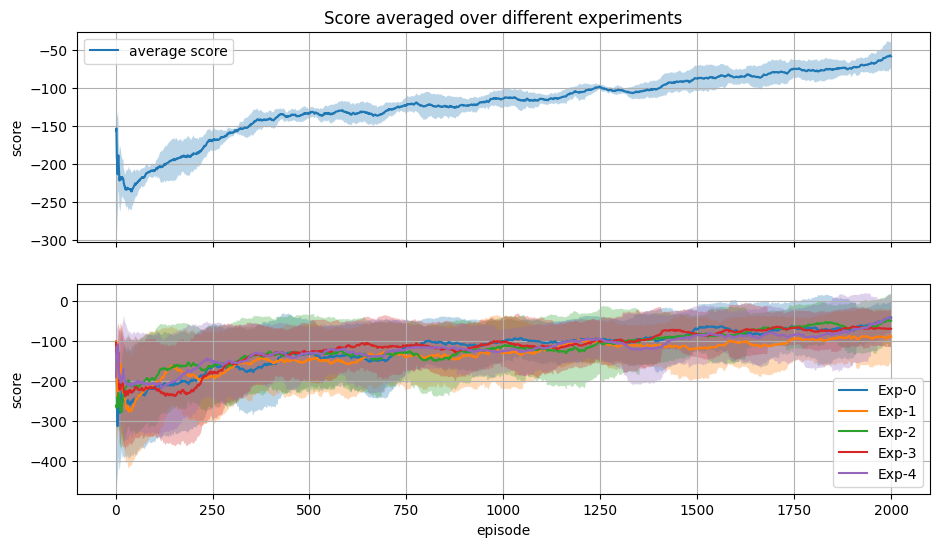

In [92]:
# save the random agent results for future comparison
results_data_dict["REINFORCE"] = [avg_scores, std_scores]
plot_results(avg_scores, std_scores)

## REINFORCE with baseline with continuous action space
Now we implement the REINFORCE with baseline algorithm as it was introduced in the Reinforcement Learning - An Introduction book (Chapter 13.3) in the case of a continuous action space (Chapter 13.7). The algorithm is specified in the figure below
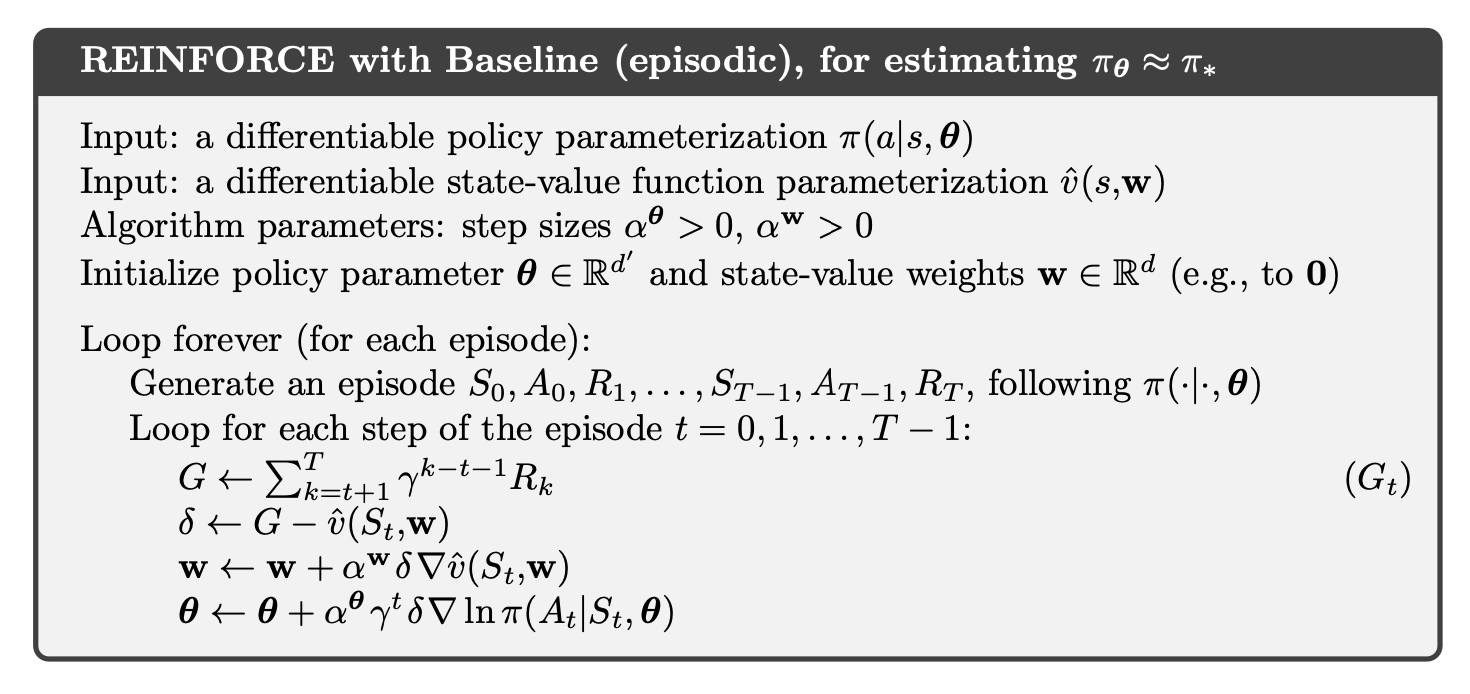

So let's get started

### The Policy and Value Networks
Actually, the policy network is the same as for the REINFORCE algorithm case, and the value network is the same as for the REINFORCE algorithm for the discrete action space case, so we do not need to write anything new.

In [2]:
class PolicyNetwork(nn.Module):
    def __init__(self, observation_dim, action_dim, learning_rate):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=observation_dim, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.mu = nn.Linear(in_features=256, out_features=action_dim)
        self.sigma = nn.Linear(in_features=256, out_features=action_dim)
        
        self.optimizer = T.optim.Adam(params=self.parameters(), lr=learning_rate)
        self.device = ('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        sigma = T.exp(sigma)
        return mu, sigma
    
class ValueNetwork(nn.Module):
    def __init__(self, observation_dim, learning_rate):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=observation_dim, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=1)
        
        self.optimizer = T.optim.Adam(params=self.parameters(), lr=learning_rate)
        self.device = ("cuda:0" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [3]:
class ReinforceWithBaselineAgent:
    def __init__(self, observation_dim, action_dim, learning_rate, gamma):
        self.lr = learning_rate
        self.gamma = gamma
        
        # initialize policy network
        self.policy = PolicyNetwork(observation_dim=observation_dim, 
                                    action_dim=action_dim, learning_rate=self.lr)
        
        # initialize the value network
        self.value = ValueNetwork(observation_dim=observation_dim, learning_rate=self.lr)
        
        # lists for saving trajectories
        self.rewards = []
        self.log_probs = []
        self.reverse_log_probs = []
        self.returns = []
        self.values = []
        self.states = []
    
    def reset(self):
        self.rewards = []
        self.log_probs = []
        self.reverse_log_probs = []
        self.returns = []
        self.values = []
        self.states = []
    
    def choose_action(self, observation):        
        # transform to torch.Tensor and send to device
        observation = T.Tensor(observation).float().to(self.policy.device)
        
        # get the distribution parameters 
        mu, sigma = self.policy(observation)
        
        # create the distribution
        m = T.distributions.Normal(loc=mu, scale=sigma)
        
        # sample an action
        action = m.sample()
        return T.tanh(action).detach().numpy(), m.log_prob(action)
        
    
    def store_transition(self, observation, reward, log_probs):
        self.rewards.append(reward)
        self.log_probs.append(log_probs)
        self.states.append(observation)
    
    def end_episode_computation(self):
        t = len(self.rewards)
        G = 0
        while t > 0:
            t -= 1
            
            # compute the returns in reversed order
            G = self.rewards[t] + self.gamma * G
            self.returns.append(G)
            state = T.tensor(self.states[t]).float().to(self.value.device)
            self.values.append(self.value(state))
            self.reverse_log_probs.append(self.log_probs[t])
    
    def learn(self):
        # transform to torch.Tensor and send to device
        log_probs = T.stack(self.reverse_log_probs).float().to(self.policy.device)
        returns = T.Tensor(self.returns).float().unsqueeze(dim=1).to(self.policy.device)
        values = T.stack(self.values).float().to(self.value.device)
        
        # compute delta
        delta = returns - values
        
        # compute the value loss and backpropogate 
        self.value.optimizer.zero_grad()
        value_loss = F.mse_loss(values, returns)
        value_loss.backward()
        self.value.optimizer.step()
        
        
        # compute the policy loss and backpropogate
        self.policy.optimizer.zero_grad()
        loss = T.sum(-delta.detach() * log_probs).to(self.policy.device)
        loss.backward()
        self.policy.optimizer.step()

Now let us run a few experiments with REINFORCE with baseline

In [5]:
env = gym.make(
    "LunarLander-v2",
    continuous=True,
    gravity=-10.0,
    enable_wind=False,
    wind_power=0.0,
    turbulence_power=0.)

N_EXPERIMENTS = 5
N_EPISODES = 2000
MAX_STEP = 300
GAMMA = 0.99
ACTION_DIM = env.action_space.shape[0]
OBSERVATION_DIM = env.observation_space.shape[0]
LEARNING_RATE = 5e-4

scores = []
avg_scores = []
std_scores = []


for ex_i in range(N_EXPERIMENTS):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    agent = ReinforceWithBaselineAgent(observation_dim=OBSERVATION_DIM, 
                                       action_dim=ACTION_DIM, 
                                       gamma=GAMMA, 
                                       learning_rate=LEARNING_RATE)
    
    for ep_i in range(N_EPISODES):
        observation, info = env.reset()
        agent.reset()
        done = False
        score = 0
        step = 0
        
        while not done:
            step += 1
            action, log_prob = agent.choose_action(observation)
            observation_, reward, terminated, truncated, info = env.step(action)
            score += reward
            agent.store_transition(observation, reward, log_prob)
            observation = observation_
            if terminated or truncated or step==MAX_STEP:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
        agent.end_episode_computation()
        agent.learn()
        print(f"| Experiment: {ex_i:3} | Episode: {ep_i:3} | Score: {np.round(score, 2):8.5} | Avg Score: {np.round(avg_scores[ex_i][-1], 2):8.5} |")
env.close()
    

| Experiment:   0 | Episode:   0 | Score:  -249.54 | Avg Score:  -249.54 |
| Experiment:   0 | Episode:   1 | Score:  -352.98 | Avg Score:  -301.26 |
| Experiment:   0 | Episode:   2 | Score:  -243.57 | Avg Score:  -282.03 |
| Experiment:   0 | Episode:   3 | Score:  -272.03 | Avg Score:  -279.53 |
| Experiment:   0 | Episode:   4 | Score:   -209.6 | Avg Score:  -265.54 |
| Experiment:   0 | Episode:   5 | Score:  -218.08 | Avg Score:  -257.63 |
| Experiment:   0 | Episode:   6 | Score:  -313.72 | Avg Score:  -265.65 |
| Experiment:   0 | Episode:   7 | Score:  -381.68 | Avg Score:  -280.15 |
| Experiment:   0 | Episode:   8 | Score:  -207.16 | Avg Score:  -272.04 |
| Experiment:   0 | Episode:   9 | Score:    15.77 | Avg Score:  -243.26 |
| Experiment:   0 | Episode:  10 | Score:  -118.57 | Avg Score:  -231.92 |
| Experiment:   0 | Episode:  11 | Score:  -112.15 | Avg Score:  -221.94 |
| Experiment:   0 | Episode:  12 | Score:  -303.03 | Avg Score:  -228.18 |
| Experiment:   0 | Episo

| Experiment:   0 | Episode: 111 | Score:  -132.28 | Avg Score:   -173.3 |
| Experiment:   0 | Episode: 112 | Score:  -123.56 | Avg Score:  -171.51 |
| Experiment:   0 | Episode: 113 | Score:   -85.02 | Avg Score:  -169.59 |
| Experiment:   0 | Episode: 114 | Score:  -304.46 | Avg Score:  -172.03 |
| Experiment:   0 | Episode: 115 | Score:   -50.11 | Avg Score:  -171.53 |
| Experiment:   0 | Episode: 116 | Score:  -125.36 | Avg Score:  -169.91 |
| Experiment:   0 | Episode: 117 | Score:   -35.54 | Avg Score:  -166.41 |
| Experiment:   0 | Episode: 118 | Score:   -96.31 | Avg Score:  -164.31 |
| Experiment:   0 | Episode: 119 | Score:  -112.73 | Avg Score:  -163.87 |
| Experiment:   0 | Episode: 120 | Score:   -71.54 | Avg Score:  -161.28 |
| Experiment:   0 | Episode: 121 | Score:  -114.89 | Avg Score:  -160.97 |
| Experiment:   0 | Episode: 122 | Score:   -141.9 | Avg Score:  -159.22 |
| Experiment:   0 | Episode: 123 | Score:   -62.36 | Avg Score:  -158.91 |
| Experiment:   0 | Episo

KeyboardInterrupt: 

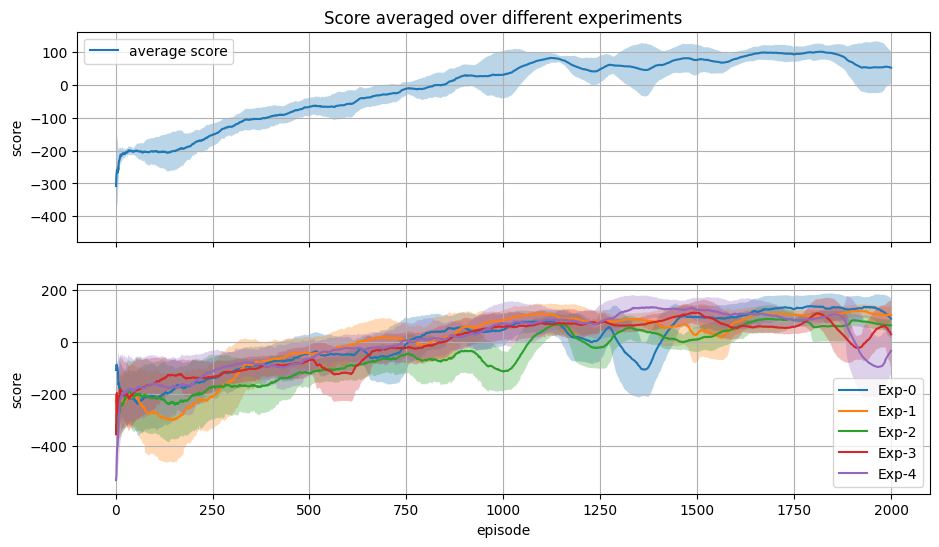

In [97]:
# save the random agent results for future comparison
results_data_dict["REINFORCE with baseline"] = [avg_scores, std_scores]
plot_results(avg_scores, std_scores)

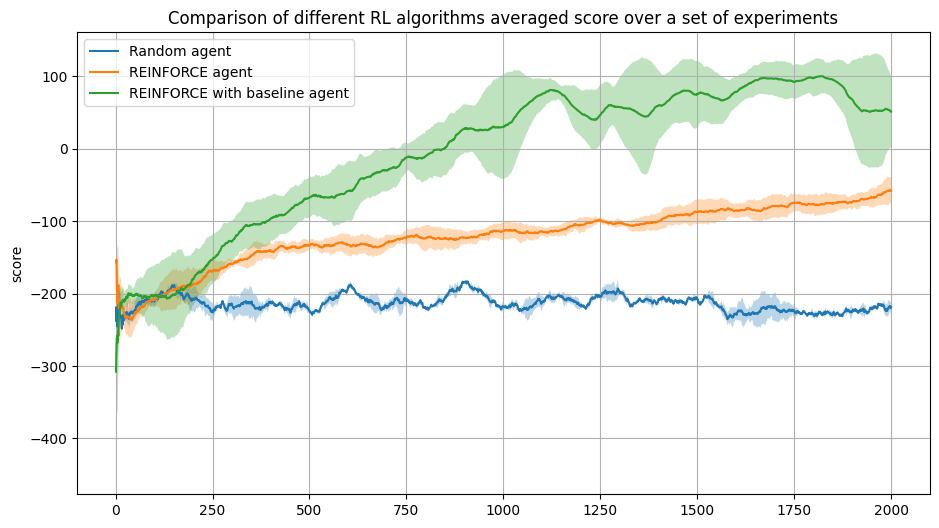

In [98]:
compare_results(results_data_dict)

## Conclusion
In the aforementioned notebook, we have seen implementations for the *REINFORCE* and *REINFORCE with baseline* algorithms for environments with continuous action spaces, as they were introduced in [1] (Chapters 13.3 and 13.4).
It is easy to see from the comparison of the two results plots, that *REINFORCE with baseline* reaches for batter results than the original *REINFORCE* algorithm, however, both behave very unstable in the training process and have high variance in terms of performance. This is a known problem of all the Monte-Carlo based RL algorithms. The next improvement would be to actually consider the value function in the estimation of the return, and switch to a Temporal Difference (TD) update method. In that case we will end up with the so-called *Actor-Critic* algorithm, where the Actor is given by the policy network, and the Critic is given by the value network.

## References
[1] Sutton & Barto, Reinforcement Learning An Introduction -Second edition (2018)

## Contact
If you find any errors or have any comments, corrections or questions about the material presented in the notebook, please do not hesitate to contact me at elkabetz.roy@gmail.com